In [38]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import os

pathDefectTile = "./DefectTiles/"
pathDefectTileStrict = "./tiles/defect/"
pathGoodTile = "./tiles/normal/"


In [39]:
class Tile:   
    x = 0
    y = 0
    width = 0
    height = 0
    imagex = 0
    imagey = 0
    roi = None
    status = -1 # -1 unsipected, 0 good, 1 defect

    def __init__(self,x, y, overlap, width, height, imagex, imagey):
        self.x = x
        self.y = y
        self.width = width
        self.height = height

        self.imagex = imagex
        self.imagey = imagey

    def populate(self,master):
        y = self.imagey
        x = self.imagex
        height = self.height
        width = self.width
        self.roi = master[y:y+height, x:x+width]


In [40]:
def setLims(img, low, high): # sets highest and lowest pixel 
    new = []
    for row in img:
        newRow = []
        for pixel in row:
            if pixel < low:
                newRow.append(np.uint8(low))
            elif pixel > high:
                newRow.append(np.uint8(high))
            else:
                newRow.append(np.uint8(pixel))
        new.append(newRow)
                
    return np.asarray(new) # though this would help fixs shawdows but gave limited results
    

In [41]:
def findDefect(img, threshHold):
    exitCode = 0 # an exit code of 0 means a blob has been detected
    
    greyMaster = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # grey blob defect

    # Light blur to lighten up and reduce size of small shadows
    lightBlur = cv2.blur(greyMaster, (5,5)) # used instead of gauusian blur for time efficirncy
    adjusted = setLims(lightBlur, 0 ,110) #Needed but massively increases time to run
#     adjusted = lightBlur

    kernel = np.ones((5,5),np.uint8) # forms the matrix used when eroading
    erosion = cv2.erode(adjusted,kernel,iterations = 1)
    
    # large blur to hide background weave and increase the size of defects
    greyBlur = cv2.blur(erosion, (15,15))

    # do adaptive threshold on gray image
    thresh = cv2.adaptiveThreshold(greyBlur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 101, 3) #doesnt work with erroision
#     thresh = cv2.adaptiveThreshold(greyBlur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, 3) #doesnt work with erroision

    # apply morphology open then close
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    blob = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9,9))
    blob = cv2.morphologyEx(blob, cv2.MORPH_CLOSE, kernel)

    # invert blob
    blob = (255 - blob)

    # Get contours
    cnts = cv2.findContours(blob, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    if(len(cnts) == 0):
        exitCode = 2 # no countours found
        
    # initalisng return varibles if no countours ar found
    result = None
    imageMean = 0
    blobMean = 0
    blob_area = 0
    
    if(exitCode == 0):
        big_contour = max(cnts, key=cv2.contourArea)

        # test blob size was 500
        blob_area_thresh = threshHold
        blob_area = cv2.contourArea(big_contour)
        if blob_area < blob_area_thresh:
            exitCode = 1 # blob is too small

        # draw contour
        result = greyMaster.copy()
        cv2.drawContours(result, [big_contour], -1, (0,0,255), 1)

        imageMean = cv2.mean(greyMaster)[0]

        # creates a mask of the blob shape, this can be applied to the orignal image to get the mean pixel color of the blob
        mask = np.zeros(greyMaster.shape, np.uint8) 
        cv2.drawContours(mask, big_contour, -1, 255, -1) 

        blobMean = cv2.mean(greyMaster, mask=mask)[0]

    return result, imageMean, blobMean,blob_area, exitCode
    


In [42]:
# importing test tiles. Do not need to be partitioned as test train sets as its rule based

goodNamesAll = os.listdir(pathGoodTile)
goodNames = []

indexes = np.random.randint(0, len(goodNamesAll)-1, size=1000)

for i in indexes:
    goodNames.append(goodNamesAll[i])
    
print(len(goodNames))

goodTilesIms = []

for name in goodNames:
    goodTilesIms.append(cv2.imread(pathGoodTile+name))
    


1000


In [43]:
defectNames = os.listdir(pathDefectTileStrict)

print(len(defectNames))

defectTilesIms = []

for name in defectNames:
    defectTilesIms.append(cv2.imread(pathDefectTileStrict+name))


909


In [44]:
TrueNoDefect = 0
FalseNoDefect  = 0
times = []

for im in goodTilesIms:
    start = time.perf_counter()
    result, imageMean, blobMean,blob_area, exitCode = findDefect(im, 100)
    times.append(time.perf_counter() - start)
    if (exitCode > 0):
        TrueNoDefect = TrueNoDefect +1
    else:
        FalseNoDefect = FalseNoDefect +1
        
print(TrueNoDefect, FalseNoDefect)
    


832 168


In [45]:
TrueDefect = 0
FalseDefect  = 0

for im in defectTilesIms:
    start = time.perf_counter()
    result, imageMean, blobMean,blob_area, exitCode = findDefect(im, 100)
    times.append(time.perf_counter() - start)
    if (exitCode == 0):
        TrueDefect = TrueDefect +1
    else:
        FalseDefect = FalseDefect +1
        
print(TrueDefect, FalseDefect)

655 254


In [46]:
print("Correctly computed good tiles =", TrueNoDefect, ",Fasly computed good tiles =", FalseNoDefect)
print("Correctly computed defcet tiles =", TrueDefect, ",Fasly computed defect tiles =", FalseDefect)
Accuracy = 100 * ((TrueNoDefect+TrueDefect) / (TrueNoDefect+TrueDefect+FalseNoDefect+FalseDefect))
print("Accuracy of", Accuracy)
print("with time per tile:", sum(times) / len(times))


Correctly computed good tiles = 832 ,Fasly computed good tiles = 168
Correctly computed defcet tiles = 655 ,Fasly computed defect tiles = 254
Accuracy of 77.89418543740179
with time per tile: 0.015610493662620267


--------------------------------


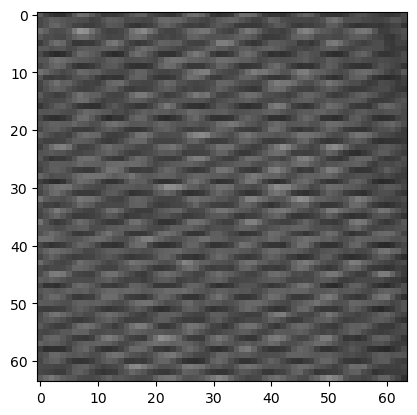

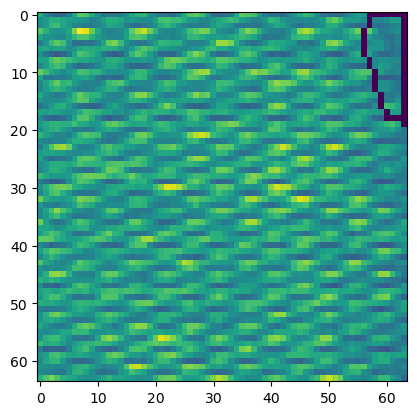

--------------------------------


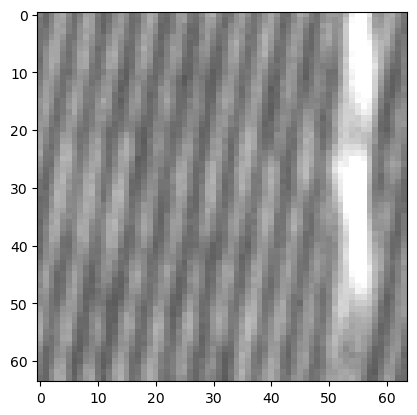

--------------------------------


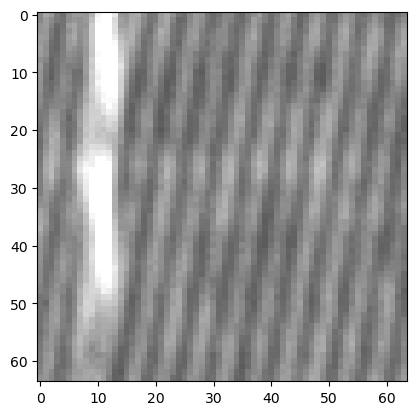

--------------------------------


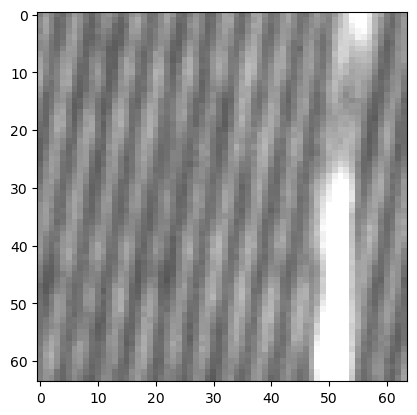

--------------------------------


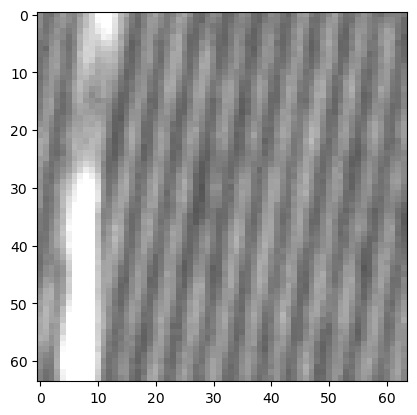

--------------------------------


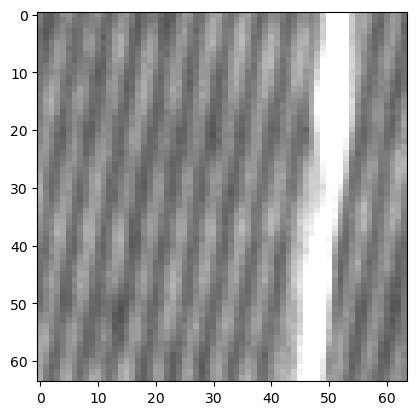

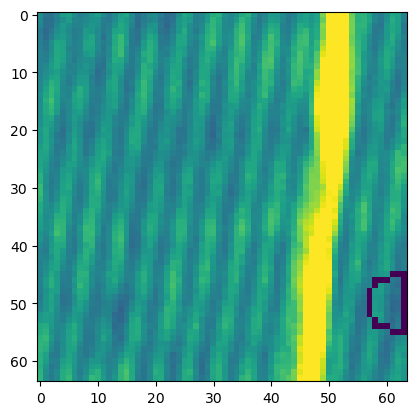

--------------------------------


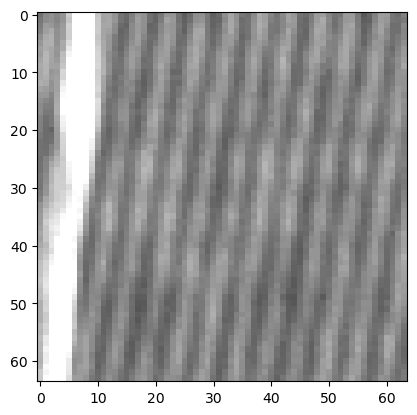

--------------------------------


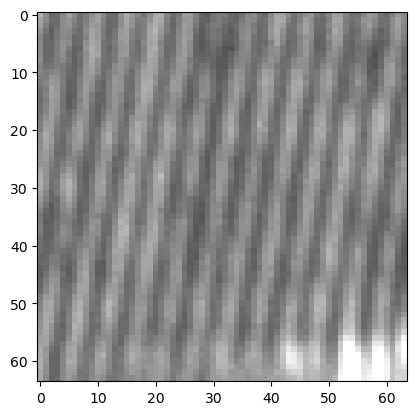

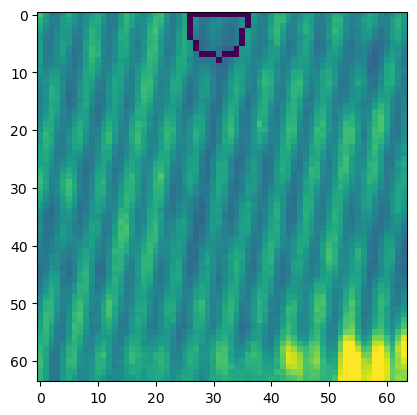

--------------------------------


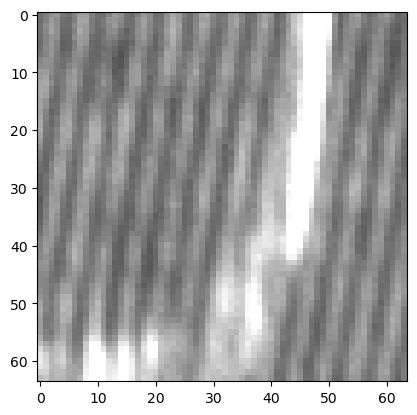

--------------------------------


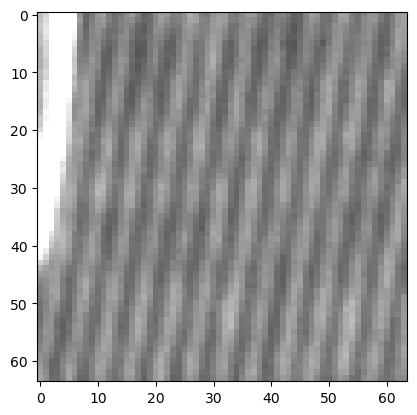

--------------------------------


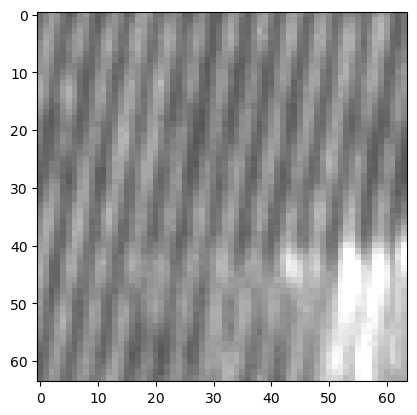

--------------------------------


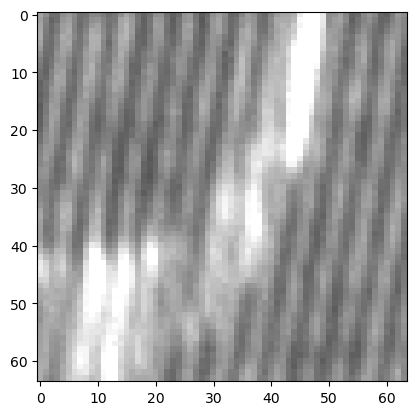

--------------------------------


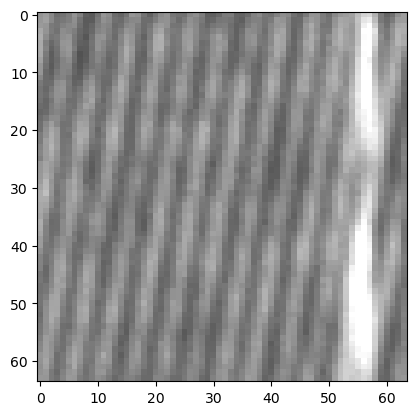

--------------------------------


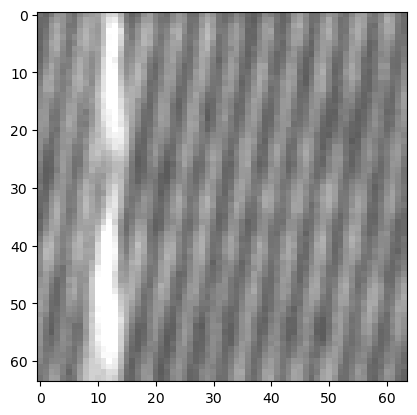

--------------------------------


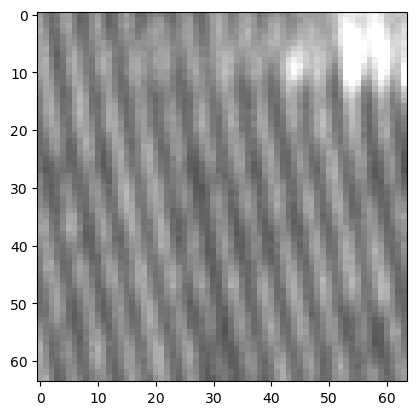

--------------------------------


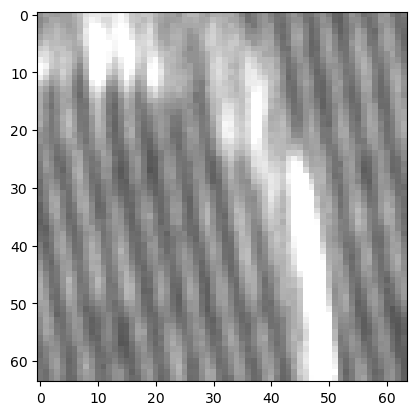

--------------------------------


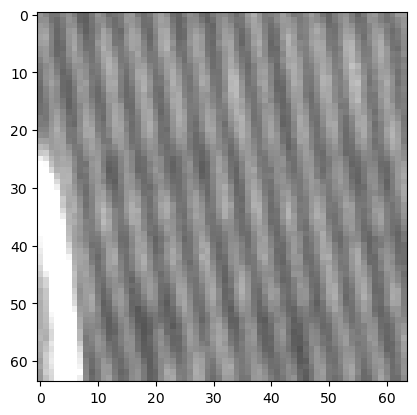

--------------------------------


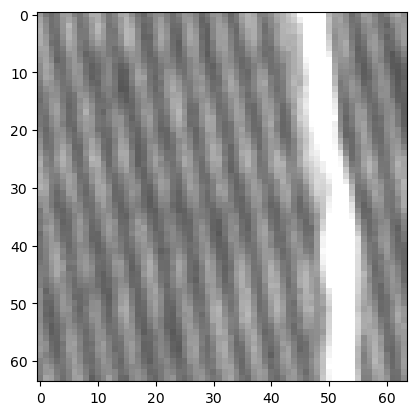

--------------------------------


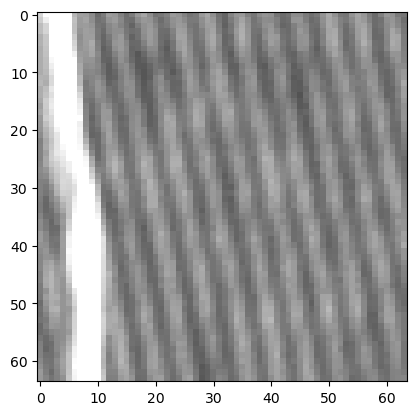

--------------------------------


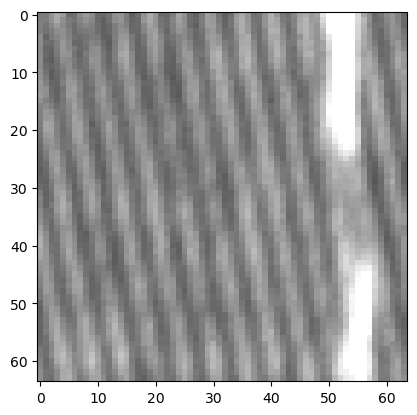

In [47]:
# showing the defctive tiles that were predicted wrong

num = 0

for im in defectTilesIms:
    result, imageMean, blobMean,blob_area, exitCode = findDefect(im, 100)
    if (exitCode > 0):
        print("--------------------------------")
        plt.imshow(im)
        plt.show()
        if exitCode == 1:
            plt.imshow(result)
            plt.show()
        num = num+ 1
        
        if num == 20:
            break
    


Creating a function to run the findDefect twice after inverting the picture to find white defects

In [48]:
def twoPassInspection(img, threshHold):
    result, imageMean, blobMean,blob_area, exitCode = findDefect(img,100)
    if(exitCode > 0):
        img = cv2.bitwise_not(img)
        result, imageMean, blobMean,blob_area, exitCode= findDefect(img,100)
    return result, imageMean, blobMean,blob_area, exitCode


In [49]:
TrueNoDefect = 0
FalseNoDefect  = 0
times = []

for im in goodTilesIms:
    start = time.perf_counter()
    result, imageMean, blobMean,blob_area, exitCode = twoPassInspection(im, 100)
    times.append(time.perf_counter() - start)
    if (exitCode > 0):
        TrueNoDefect = TrueNoDefect +1
    else:
        FalseNoDefect = FalseNoDefect +1
        
print(TrueNoDefect, FalseNoDefect)
    


770 230


In [50]:
TrueDefect = 0
FalseDefect  = 0

for im in defectTilesIms:
    start = time.perf_counter()
    result, imageMean, blobMean,blob_area, exitCode = twoPassInspection(im, 100)
    times.append(time.perf_counter() - start)
    if (exitCode == 0):
        TrueDefect = TrueDefect +1
    else:
        FalseDefect = FalseDefect +1
        
print(TrueDefect, FalseDefect)

734 175


In [51]:
print("Correctly computed good tiles =", TrueNoDefect, ",Fasly computed good tiles =", FalseNoDefect)
print("Correctly computed defcet tiles =", TrueDefect, ",Fasly computed defect tiles =", FalseDefect)
Accuracy = 100 * ((TrueNoDefect+TrueDefect) / (TrueNoDefect+TrueDefect+FalseNoDefect+FalseDefect))
print("Accuracy of", Accuracy)
print("with time per tile:", sum(times) / len(times))



Correctly computed good tiles = 770 ,Fasly computed good tiles = 230
Correctly computed defcet tiles = 734 ,Fasly computed defect tiles = 175
Accuracy of 78.78470403352541
with time per tile: 0.027561511783414233


--------------------------------


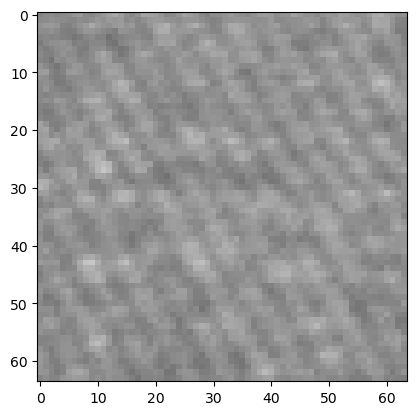

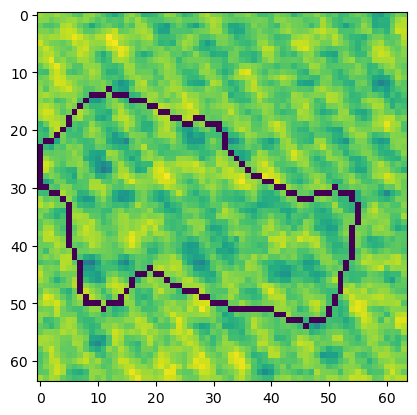

--------------------------------


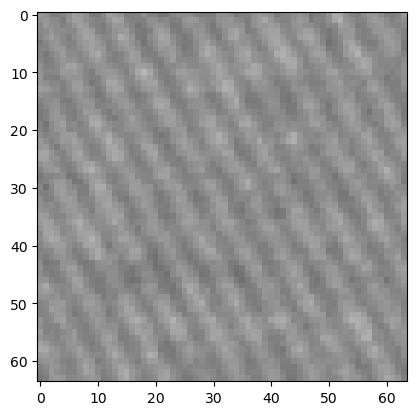

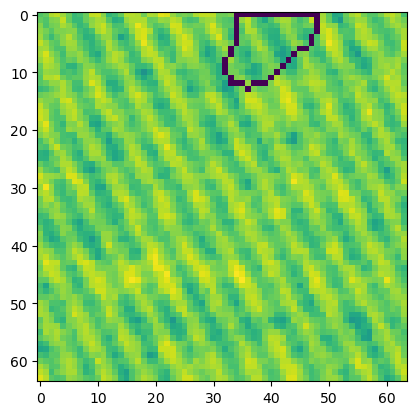

--------------------------------


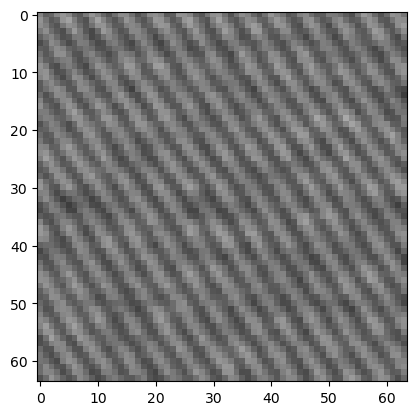

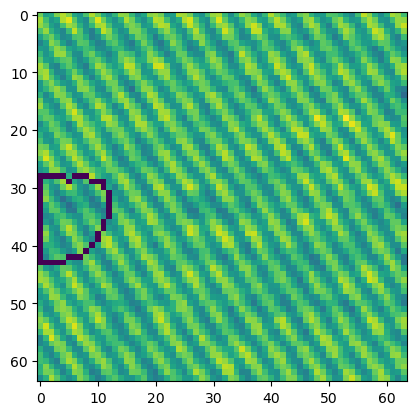

--------------------------------


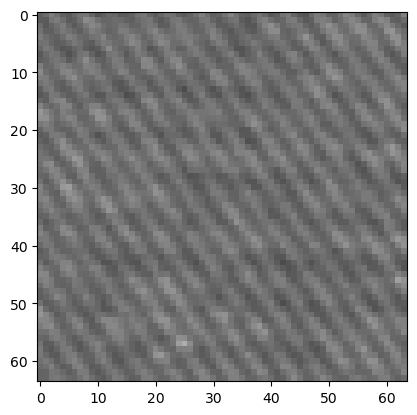

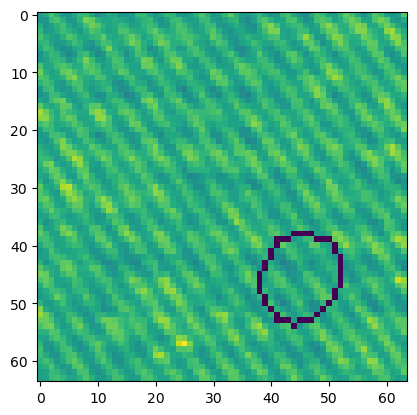

--------------------------------


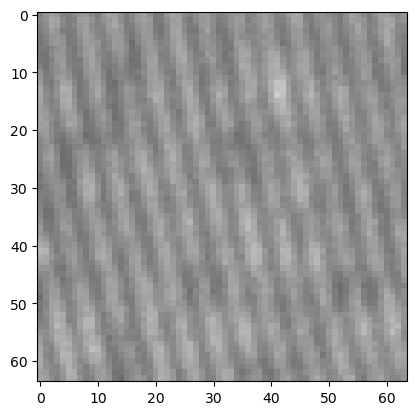

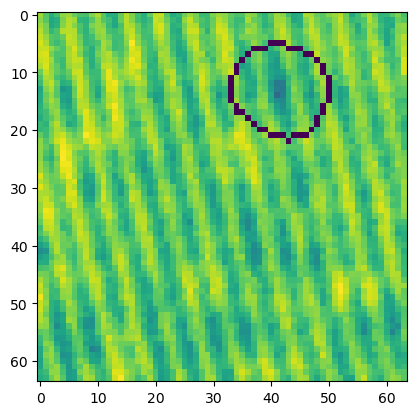

--------------------------------


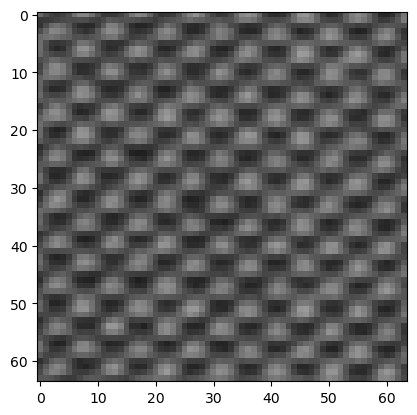

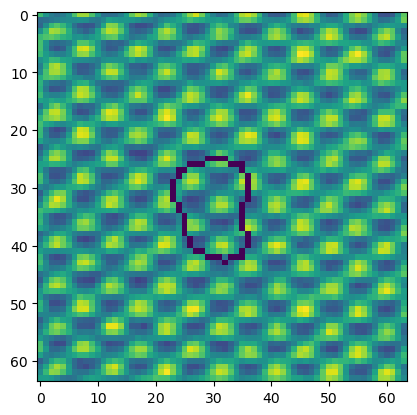

--------------------------------


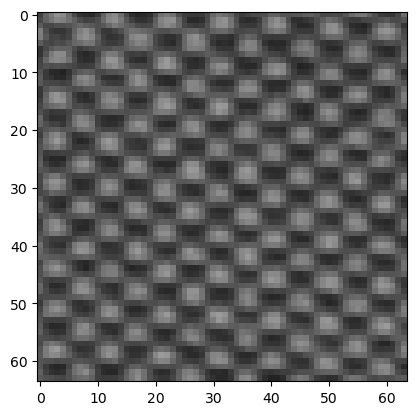

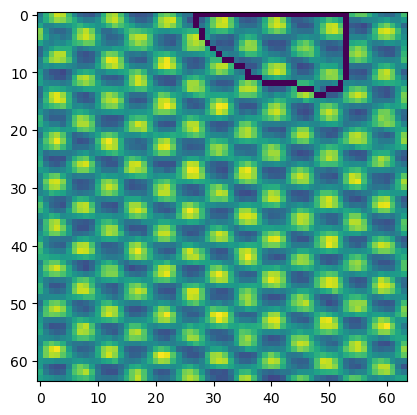

--------------------------------


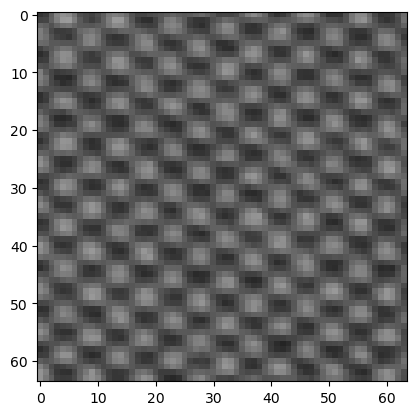

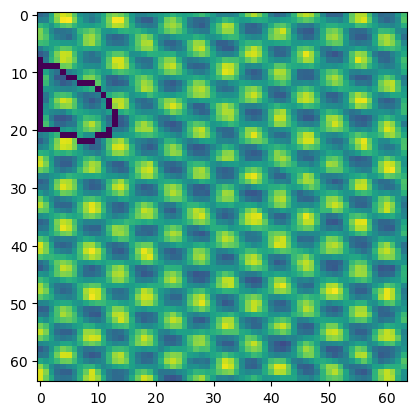

--------------------------------


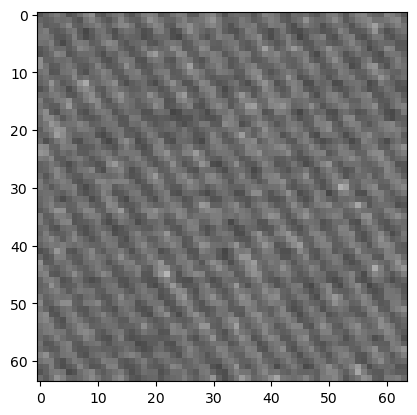

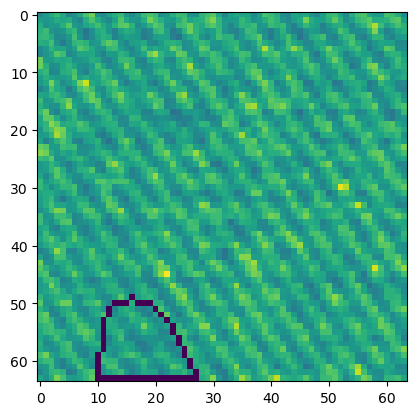

--------------------------------


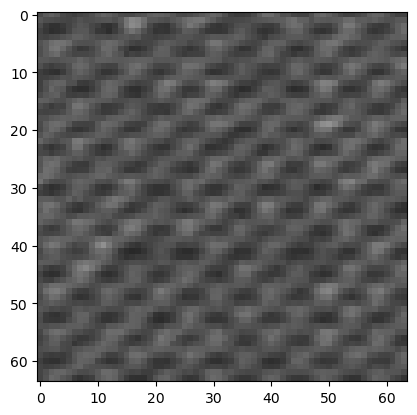

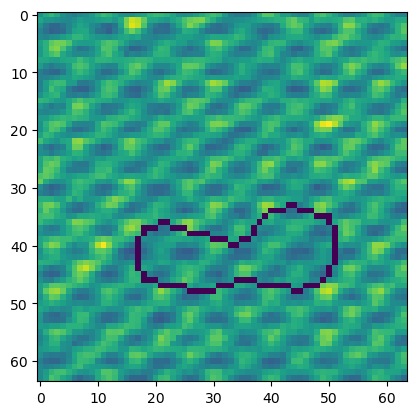

--------------------------------


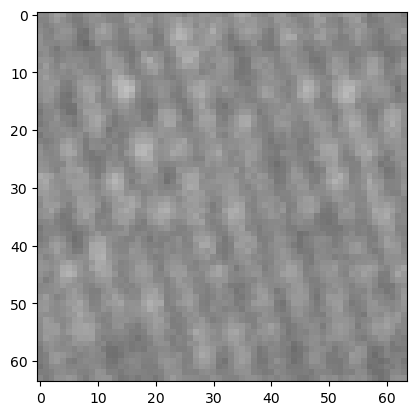

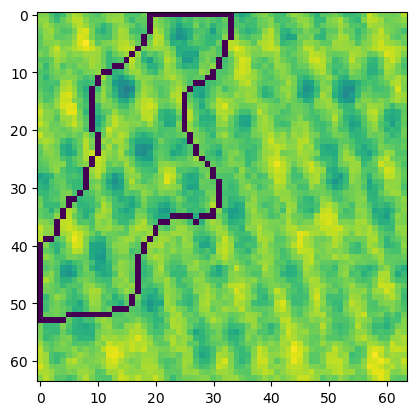

--------------------------------


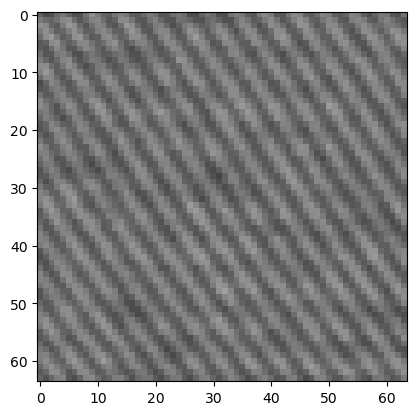

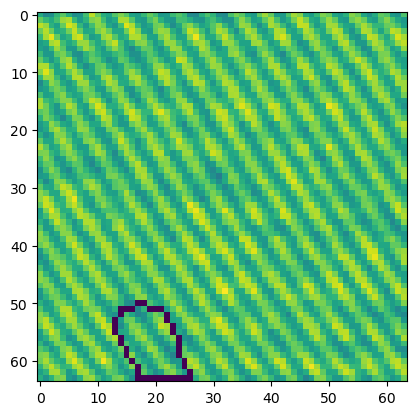

--------------------------------


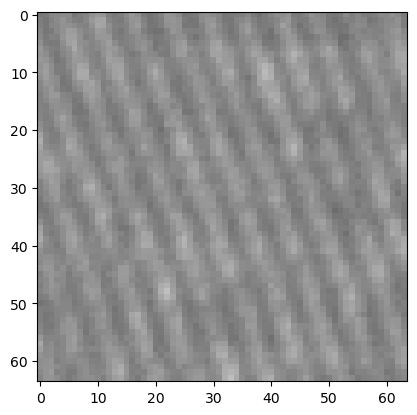

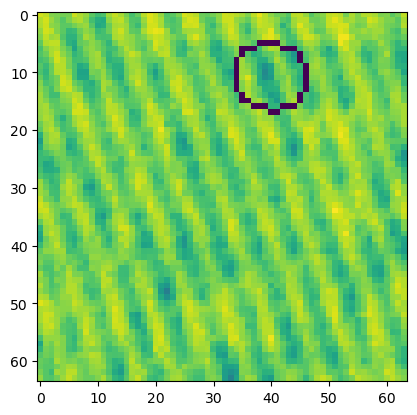

--------------------------------


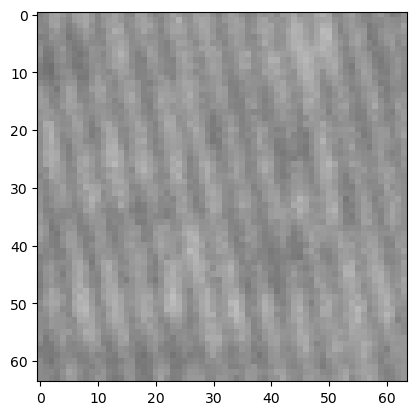

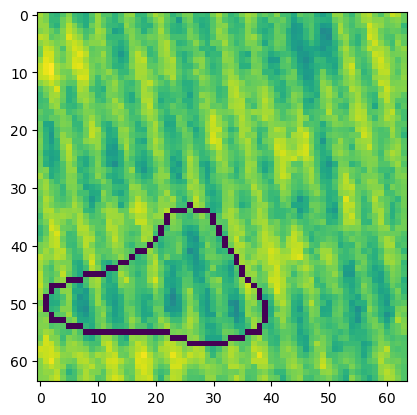

--------------------------------


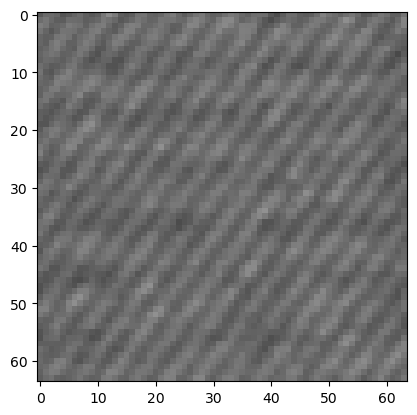

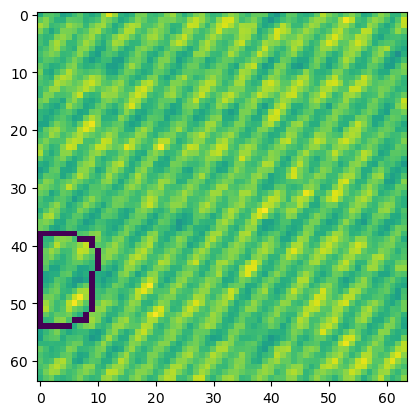

--------------------------------


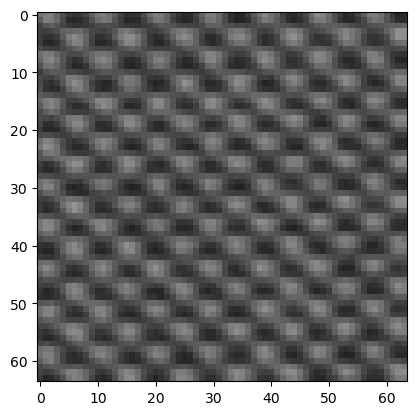

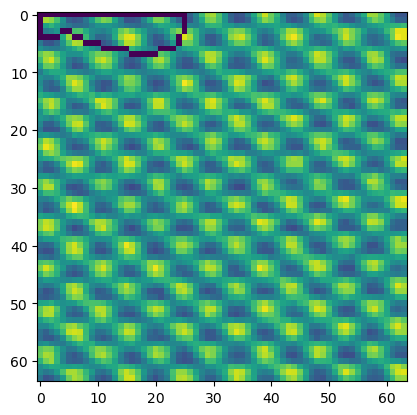

--------------------------------


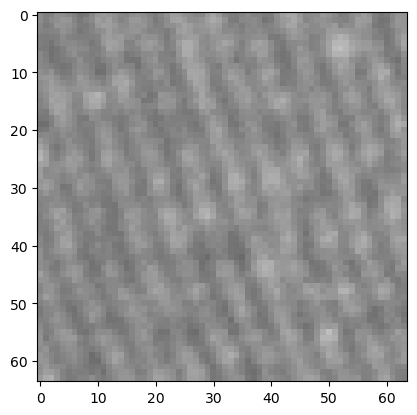

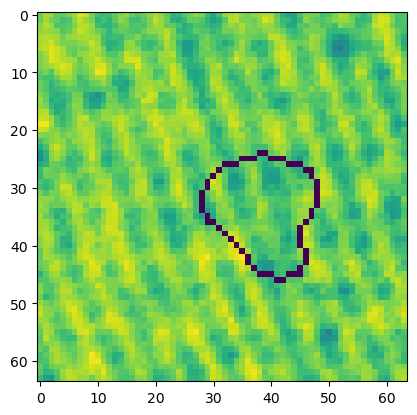

--------------------------------


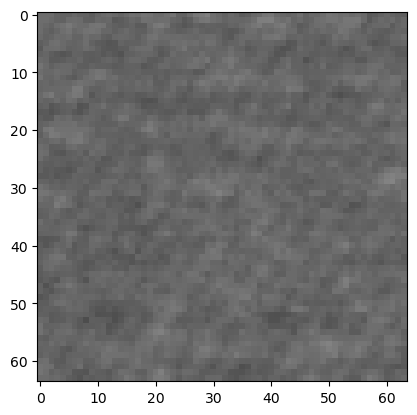

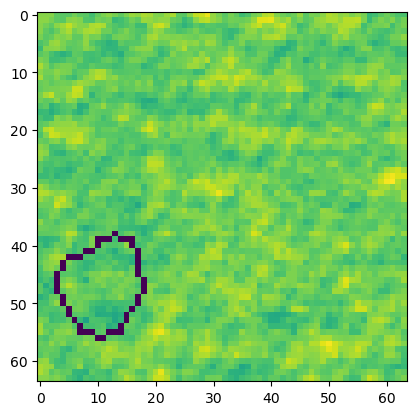

--------------------------------


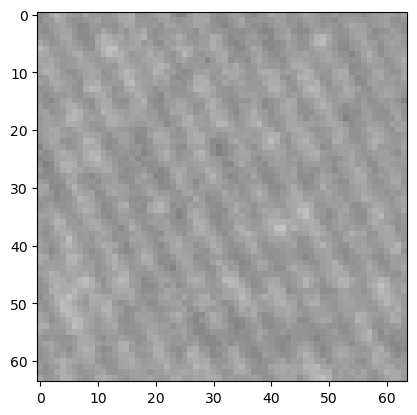

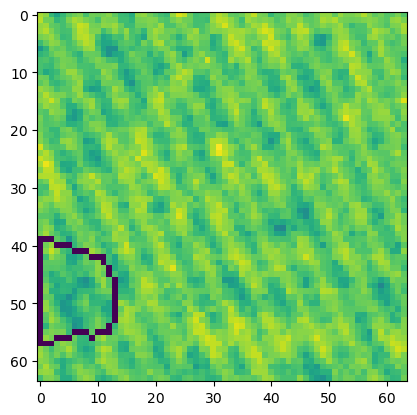

--------------------------------


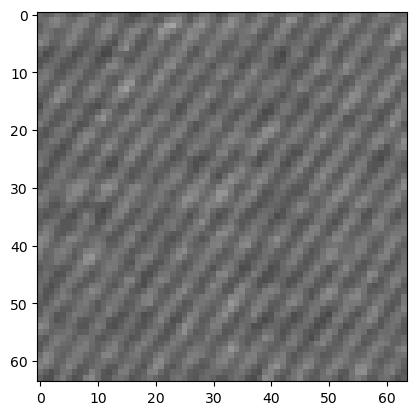

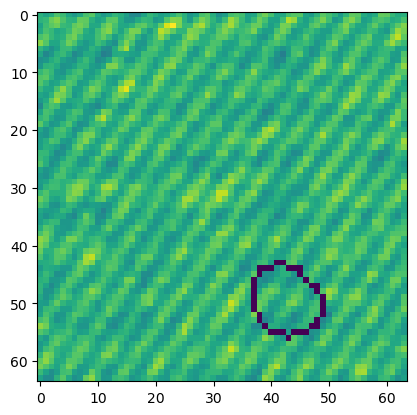

In [52]:
num = 0

for im in goodTilesIms:
    result, imageMean, blobMean,blob_area, exitCode = twoPassInspection(im, 100)
    if (exitCode == 0):
        print("--------------------------------")
        plt.imshow(im)
        plt.show()
        plt.imshow(result)
        plt.show()
        num = num+ 1
        
        if num == 20:
            break
    


--------------------------------


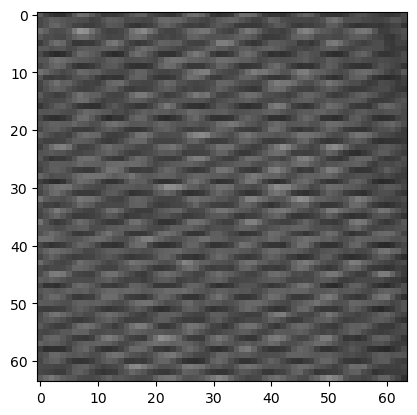

--------------------------------


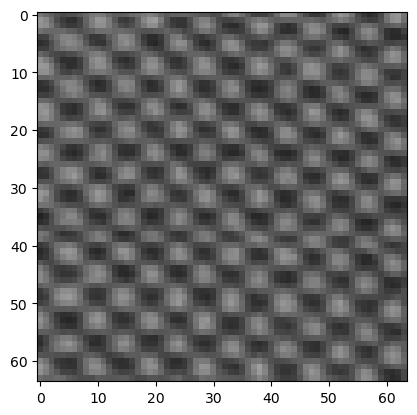

--------------------------------


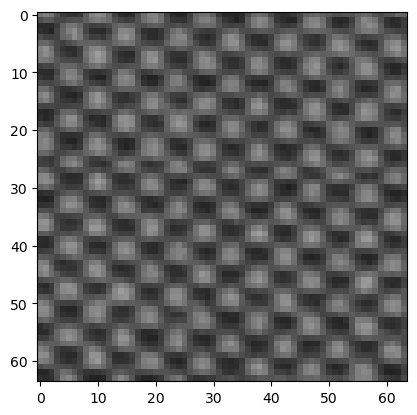

--------------------------------


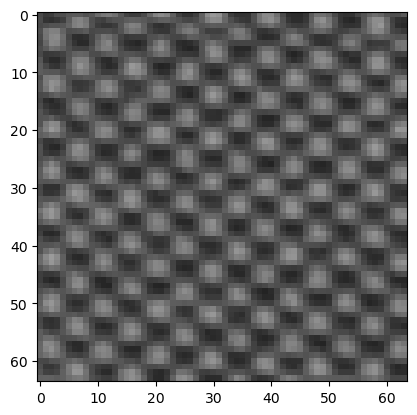

--------------------------------


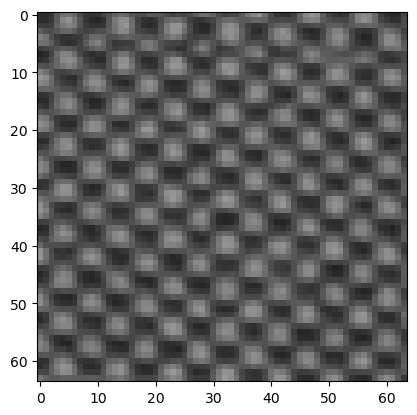

--------------------------------


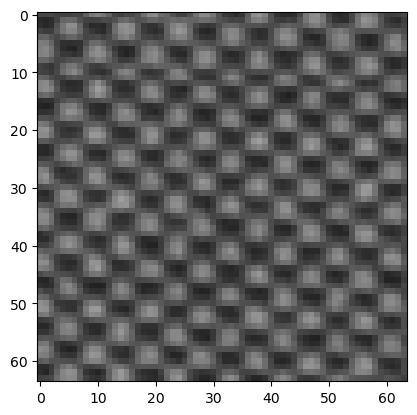

--------------------------------


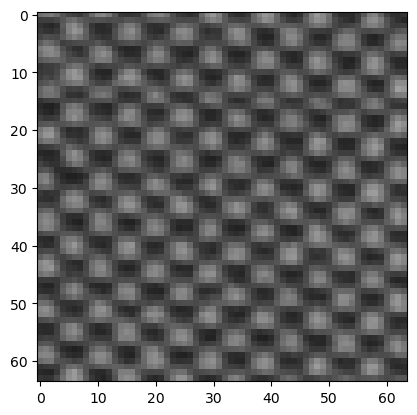

--------------------------------


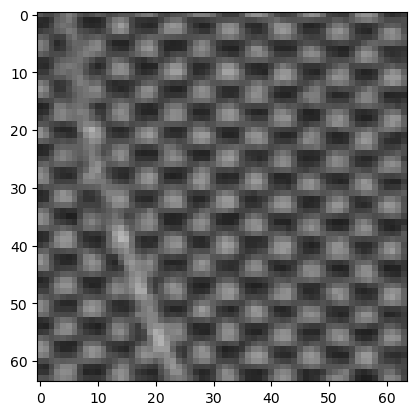

--------------------------------


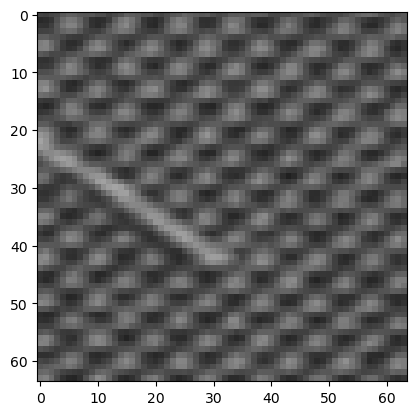

--------------------------------


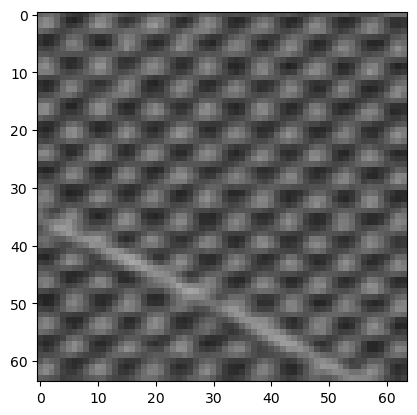

--------------------------------


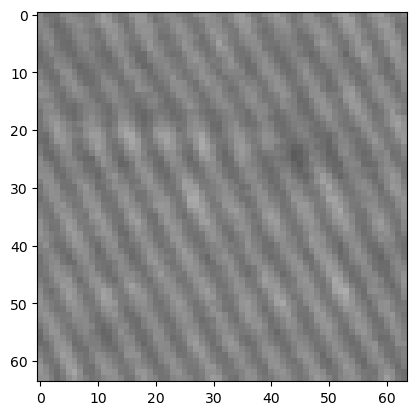

--------------------------------


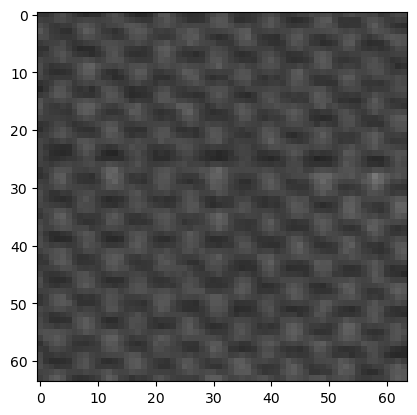

--------------------------------


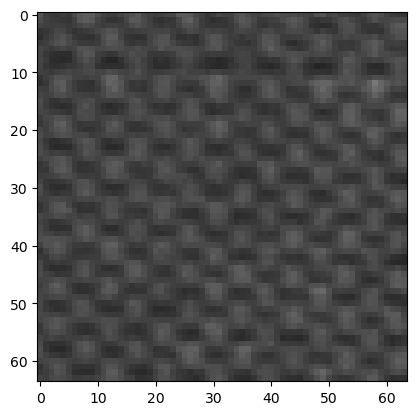

--------------------------------


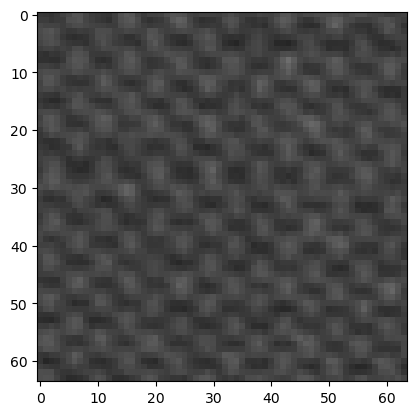

--------------------------------


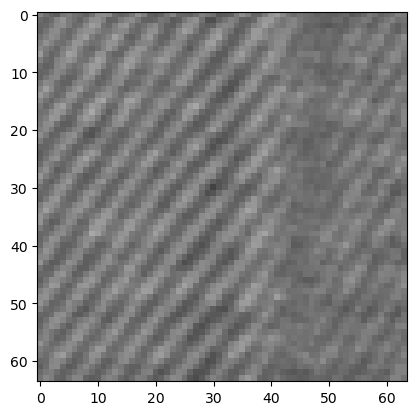

--------------------------------


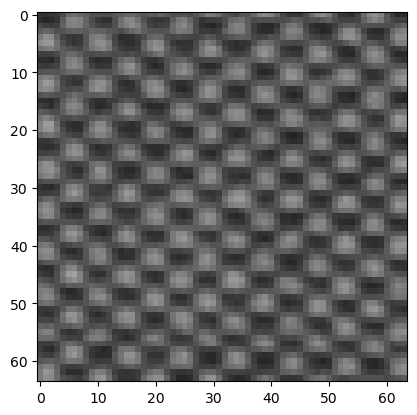

--------------------------------


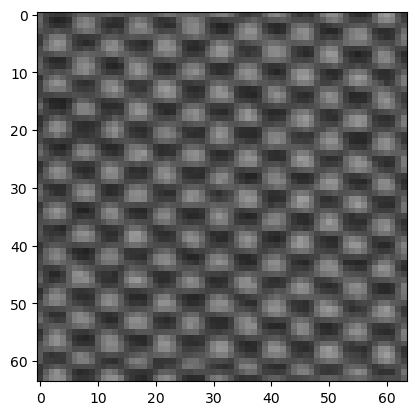

--------------------------------


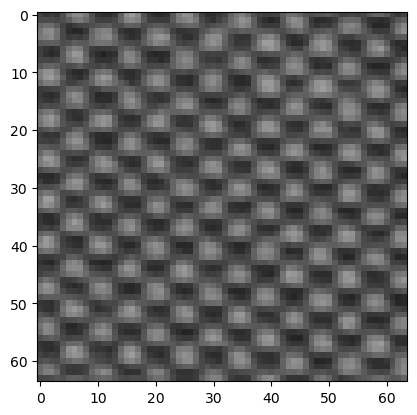

--------------------------------


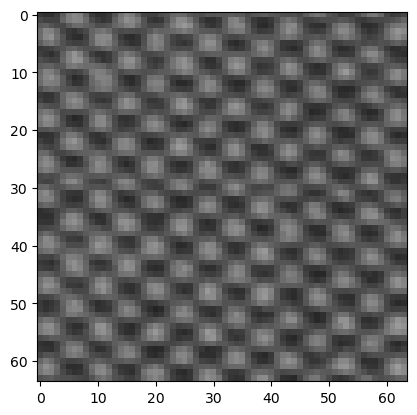

--------------------------------


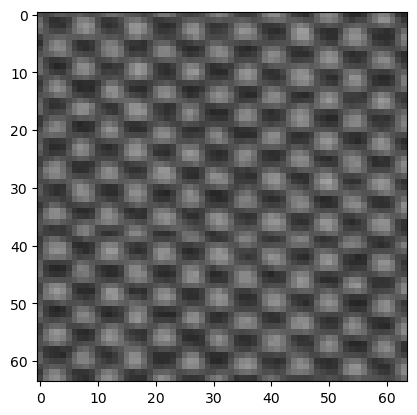

In [53]:
num = 0

for im in defectTilesIms:
    result, imageMean, blobMean,blob_area, exitCode = twoPassInspection(im, 100)
    if (exitCode > 0):
        print("--------------------------------")
        plt.imshow(im)
        plt.show()
        if exitCode == 1:
            plt.imshow(result)
            plt.show()
            print(blob_area)
        num = num+ 1
        
        if num == 20:
            break
    


Changing set lim function to an optomised fuction

In [54]:
def findDefect(img, threshHold):
    exitCode = 0 # an exit code of 0 means a blob has been detected
    
    greyMaster = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # grey blob defect

    # Light blur to lighten up and reduce size of small shadows
    lightBlur = cv2.blur(greyMaster, (5,5)) # used instead of gauusian blur for time efficirncy
#     adjusted = setLims(lightBlur, 0 ,110) #Needed but massively increases time to run
    ret, adjusted = cv2.threshold(lightBlur,110,110,cv2.THRESH_TRUNC)



    kernel = np.ones((5,5),np.uint8) # forms the matrix used when eroading
    erosion = cv2.erode(adjusted,kernel,iterations = 1)
    
    # large blur to hide background weave and increase the size of defects
    greyBlur = cv2.blur(erosion, (15,15))

    # do adaptive threshold on gray image
    thresh = cv2.adaptiveThreshold(greyBlur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 101, 3) #doesnt work with erroision
#     thresh = cv2.adaptiveThreshold(greyBlur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, 3) #doesnt work with erroision


    # apply morphology open then close
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    blob = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9,9))
    blob = cv2.morphologyEx(blob, cv2.MORPH_CLOSE, kernel)

    # invert blob
    blob = (255 - blob)

    # Get contours
    cnts = cv2.findContours(blob, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    if(len(cnts) == 0):
        exitCode = 2 # no countours found
        
    # initalisng return varibles if no countours ar found
    result = None
    imageMean = 0
    blobMean = 0
    blob_area = 0
    
    if(exitCode == 0):
        big_contour = max(cnts, key=cv2.contourArea)

        # test blob size was 500
        blob_area_thresh = threshHold
        blob_area = cv2.contourArea(big_contour)
        if blob_area < blob_area_thresh:
            exitCode = 1 # blob is too small

        # draw contour
        result = greyMaster.copy()
        cv2.drawContours(result, [big_contour], -1, (0,0,255), 1)

        imageMean = cv2.mean(greyMaster)[0]

        # creates a mask of the blob shape, this can be applied to the orignal image to get the mean pixel color of the blob
        mask = np.zeros(greyMaster.shape, np.uint8) 
        cv2.drawContours(mask, big_contour, -1, 255, -1) 

        blobMean = cv2.mean(greyMaster, mask=mask)[0]

    return result, imageMean, blobMean,blob_area, exitCode
    


In [55]:
TrueNoDefect = 0
FalseNoDefect  = 0
times = []

for im in goodTilesIms:
    start = time.perf_counter()
    result, imageMean, blobMean,blob_area, exitCode = twoPassInspection(im, 100)
    times.append(time.perf_counter() - start)
    if (exitCode > 0):
        TrueNoDefect = TrueNoDefect +1
    else:
        FalseNoDefect = FalseNoDefect +1
        
print(TrueNoDefect, FalseNoDefect)
    


770 230


In [56]:
TrueDefect = 0
FalseDefect  = 0

for im in defectTilesIms:
    start = time.perf_counter()
    result, imageMean, blobMean,blob_area, exitCode = twoPassInspection(im, 100)
    times.append(time.perf_counter() - start)
    if (exitCode == 0):
        TrueDefect = TrueDefect +1
    else:
        FalseDefect = FalseDefect +1
        
print(TrueDefect, FalseDefect)

734 175


In [57]:
print("Correctly computed good tiles =", TrueNoDefect, ",Fasly computed good tiles =", FalseNoDefect)
print("Correctly computed defcet tiles =", TrueDefect, ",Fasly computed defect tiles =", FalseDefect)
Accuracy = 100 * ((TrueNoDefect+TrueDefect) / (TrueNoDefect+TrueDefect+FalseNoDefect+FalseDefect))
print("Accuracy of", Accuracy)
print("with time per tile:", sum(times) / len(times))



Correctly computed good tiles = 770 ,Fasly computed good tiles = 230
Correctly computed defcet tiles = 734 ,Fasly computed defect tiles = 175
Accuracy of 78.78470403352541
with time per tile: 0.0004033972234784729


Tuining Hyper Params

In [73]:
def findDefect(img, threshHold, pixThresh, lightBlur, errode, blur):
    exitCode = 0 # an exit code of 0 means a blob has been detected
    
    greyMaster = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # grey blob defect

    # Light blur to lighten up and reduce size of small shadows
    lightBlur = cv2.blur(greyMaster, (lightBlur,lightBlur)) # used instead of gauusian blur for time efficirncy
#     adjusted = setLims(lightBlur, 0 ,110) #Needed but massively increases time to run
    ret, adjusted = cv2.threshold(lightBlur,pixThresh,pixThresh,cv2.THRESH_TRUNC)



    kernel = np.ones((errode,errode),np.uint8) # forms the matrix used when eroading
    erosion = cv2.erode(adjusted,kernel,iterations = 1)
    
    # large blur to hide background weave and increase the size of defects
    greyBlur = cv2.blur(erosion, (blur,blur))

    # do adaptive threshold on gray image
    thresh = cv2.adaptiveThreshold(greyBlur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 101, 3) #doesnt work with erroision
#     thresh = cv2.adaptiveThreshold(greyBlur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, 3)


    # apply morphology open then close
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    blob = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9,9))
    blob = cv2.morphologyEx(blob, cv2.MORPH_CLOSE, kernel)

    # invert blob
    blob = (255 - blob)

    # Get contours
    cnts = cv2.findContours(blob, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    if(len(cnts) == 0):
        exitCode = 2 # no countours found
        
    # initalisng return varibles if no countours ar found
    result = None
    imageMean = 0
    blobMean = 0
    blob_area = 0
    
    if(exitCode == 0):
        big_contour = max(cnts, key=cv2.contourArea)

        # test blob size was 500
        blob_area_thresh = threshHold
        blob_area = cv2.contourArea(big_contour)
        if blob_area < blob_area_thresh:
            exitCode = 1 # blob is too small

        # draw contour
        result = greyMaster.copy()
        cv2.drawContours(result, [big_contour], -1, (0,0,255), 1)

        imageMean = cv2.mean(greyMaster)[0]

        # creates a mask of the blob shape, this can be applied to the orignal image to get the mean pixel color of the blob
        mask = np.zeros(greyMaster.shape, np.uint8) 
        cv2.drawContours(mask, big_contour, -1, 255, -1) 

        blobMean = cv2.mean(greyMaster, mask=mask)[0]

    return result, imageMean, blobMean,blob_area, exitCode
    
    

def twoPassInspection(img, threshHold, pixThresh, lightBlur, errode, blur):
    result, imageMean, blobMean,blob_area, exitCode = findDefect(img,threshHold, pixThresh, lightBlur, errode, blur)
    img = cv2.bitwise_not(img)
    result_I, imageMean_I, blobMean_I,blob_area_I, exitCode_I= findDefect(img,threshHold,pixThresh, lightBlur, errode, blur)
    
    if(blob_area_I > blob_area):
        return result_I, imageMean_I, blobMean_I,blob_area_I, exitCode_I
    
    return result, imageMean, blobMean,blob_area, exitCode


In [74]:
bestAcc = 0
theshHolds = [50,100,150,200,250,300]
pixTheshHolds = [50,60,70,80,90,100,110,120,140]

bestThresh = 0
bestPixThresh = 0




for thresh in theshHolds:
    for pixThresh in pixTheshHolds:
        TrueNoDefect = 0
        FalseNoDefect  = 0
        TrueDefect = 0
        FalseDefect  = 0
        for im in goodTilesIms:
            result, imageMean, blobMean,blob_area, exitCode = twoPassInspection(im, thresh, pixThresh, 5, 5, 15)
            if (exitCode > 0):
                TrueNoDefect = TrueNoDefect +1
            else:
                FalseNoDefect = FalseNoDefect +1

        for im in defectTilesIms:
            result, imageMean, blobMean,blob_area, exitCode = twoPassInspection(im, thresh, pixThresh, 5, 5, 15)
            if (exitCode == 0):
                TrueDefect = TrueDefect +1
            else:
                FalseDefect = FalseDefect +1
                
        acc = 100 * ((TrueNoDefect+TrueDefect) / (TrueNoDefect+TrueDefect+FalseNoDefect+FalseDefect))
        
        print(thresh, pixThresh, acc)
        print(TrueNoDefect, FalseNoDefect)
        print(TrueDefect, FalseDefect)
        print("---------------")

        if (100 * ((TrueNoDefect+TrueDefect) / (TrueNoDefect+TrueDefect+FalseNoDefect+FalseDefect))) > bestAcc:
            bestThresh = thresh
            bestPixThresh = pixThresh
            bestAcc = 100 * ((TrueNoDefect+TrueDefect) / (TrueNoDefect+TrueDefect+FalseNoDefect+FalseDefect))
                    

50 50 56.41697223677318
998 2
79 830
---------------
50 60 57.46464117338921
997 3
100 809
---------------
50 70 72.18438973284442
943 57
435 474
---------------
50 80 81.35149292823468
859 141
694 215
---------------
50 90 83.28968046097434
839 161
751 158
---------------
50 100 83.44683080146673
806 194
787 122
---------------
50 110 75.0654793085385
618 382
815 94
---------------
50 120 60.24096385542169
329 671
821 88
---------------
50 140 53.4834992142483
188 812
833 76
---------------
100 50 56.31220534311158
998 2
77 832
---------------
100 60 56.993190151911996
998 2
90 819
---------------
100 70 68.0984808800419
977 23
323 586
---------------
100 80 77.78941854374017
917 83
568 341
---------------
100 90 81.45625982189628
897 103
658 251
---------------
100 100 82.50392875851232
875 125
700 209
---------------
100 110 78.78470403352541
770 230
734 175
---------------
100 120 67.8889470927187
557 443
739 170
---------------
100 140 58.93137768465165
365 635
760 149
-----------

In [75]:
print("best threshold:", bestThresh)
print("best pix threshold:", bestPixThresh)
print("with acc:", bestAcc)

best threshold: 50
best pix threshold: 100
with acc: 83.44683080146673


In [76]:
bestLightBlur = 0
bestErrode = 0
bestBlur = 0

bestAcc = 0


for lightBlur in range(1,10):
    for errode in range(1,10):
        for blur in range(1,20):
            TrueNoDefect = 0
            FalseNoDefect  = 0
            TrueDefect = 0
            FalseDefect  = 0
            for im in goodTilesIms:
                result, imageMean, blobMean,blob_area, exitCode = twoPassInspection(im, bestThresh, bestPixThresh, lightBlur, errode, blur)
                if (exitCode > 0):
                    TrueNoDefect = TrueNoDefect +1
                else:
                    FalseNoDefect = FalseNoDefect +1

            for im in defectTilesIms:
                result, imageMean, blobMean,blob_area, exitCode = twoPassInspection(im, bestThresh, bestPixThresh, lightBlur, errode, blur)
                if (exitCode == 0):
                    TrueDefect = TrueDefect +1
                else:
                    FalseDefect = FalseDefect +1

            if (100 * ((TrueNoDefect+TrueDefect) / (TrueNoDefect+TrueDefect+FalseNoDefect+FalseDefect))) > bestAcc:
                bestLightBlur = lightBlur
                bestErrode = errode
                bestBlur = blur
                bestAcc = 100 * ((TrueNoDefect+TrueDefect) / (TrueNoDefect+TrueDefect+FalseNoDefect+FalseDefect))

In [77]:
print("best threshold:", bestThresh)
print("best pix threshold:", bestPixThresh)
print("best LightBlur:", bestLightBlur)
print("best errode:", bestErrode)
print("best blur:", bestBlur)
print("with accuracy of:", bestAcc)

best threshold: 50
best pix threshold: 100
best LightBlur: 6
best errode: 7
best blur: 17
with accuracy of: 84.86118386589837


In [78]:
TrueNoDefect = 0
FalseNoDefect  = 0
times = []

for im in goodTilesIms:
    start = time.perf_counter()
    result, imageMean, blobMean,blob_area, exitCode = twoPassInspection(im, bestThresh, bestPixThresh, bestLightBlur, bestErrode, bestBlur)
    times.append(time.perf_counter() - start)
    if (exitCode > 0):
        TrueNoDefect = TrueNoDefect +1
    else:
        FalseNoDefect = FalseNoDefect +1
        
print(TrueNoDefect, FalseNoDefect)
    
TrueDefect = 0
FalseDefect  = 0

for im in defectTilesIms:
    start = time.perf_counter()
    result, imageMean, blobMean,blob_area, exitCode = twoPassInspection(im, bestThresh, bestPixThresh, bestLightBlur, bestErrode, bestBlur)
    times.append(time.perf_counter() - start)
    if (exitCode == 0):
        TrueDefect = TrueDefect +1
    else:
        FalseDefect = FalseDefect +1
        
print(TrueDefect, FalseDefect)

print("Correctly computed good tiles =", TrueNoDefect, ",Fasly computed good tiles =", FalseNoDefect)
print("Correctly computed defcet tiles =", TrueDefect, ",Fasly computed defect tiles =", FalseDefect)
Accuracy = 100 * ((TrueNoDefect+TrueDefect) / (TrueNoDefect+TrueDefect+FalseNoDefect+FalseDefect))
print("Accuracy of", Accuracy)
print("with time per tile:", sum(times) / len(times))

803 197
817 92
Correctly computed good tiles = 803 ,Fasly computed good tiles = 197
Correctly computed defcet tiles = 817 ,Fasly computed defect tiles = 92
Accuracy of 84.86118386589837
with time per tile: 0.00032507673939207013


--------------------------------


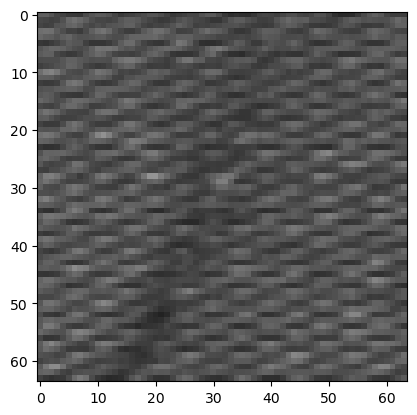

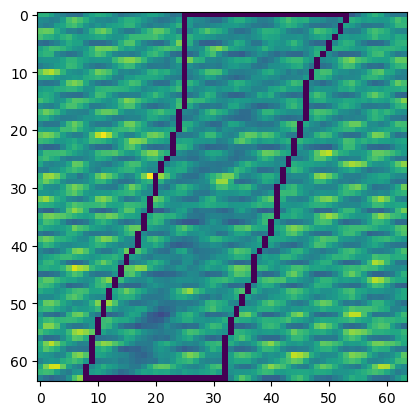

1432.0
--------------------------------


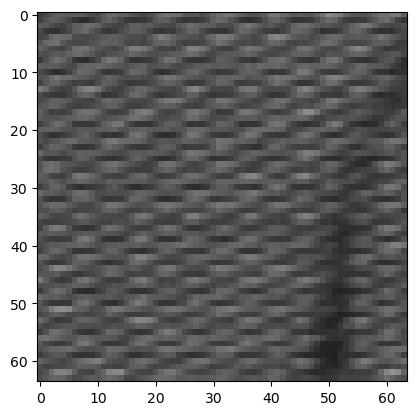

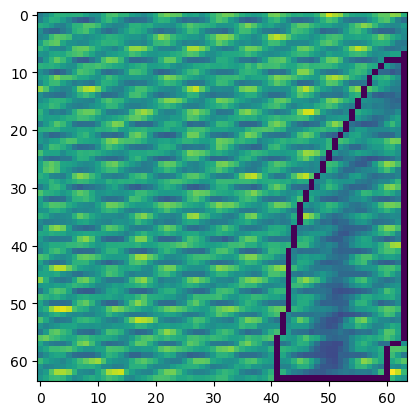

860.0
--------------------------------


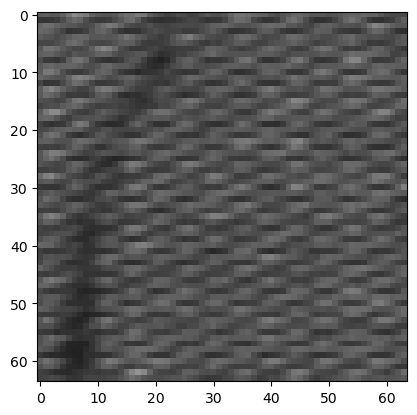

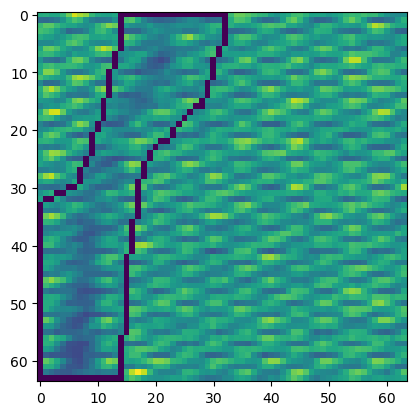

947.5
--------------------------------


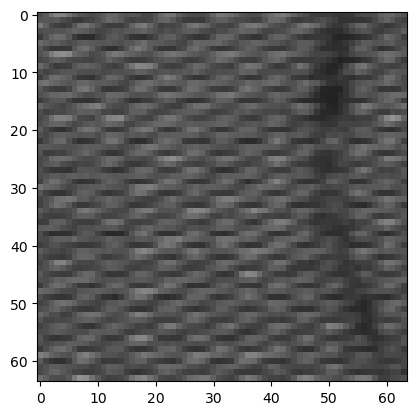

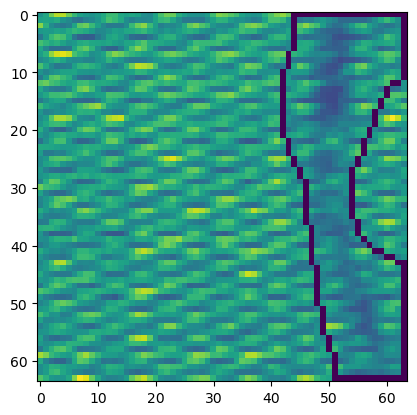

880.5
--------------------------------


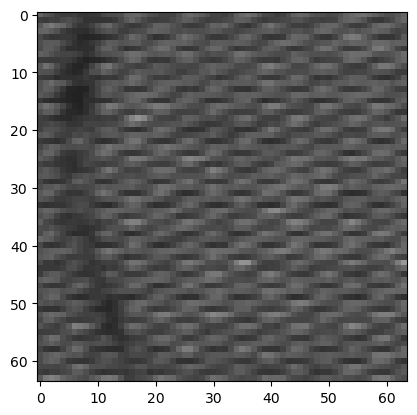

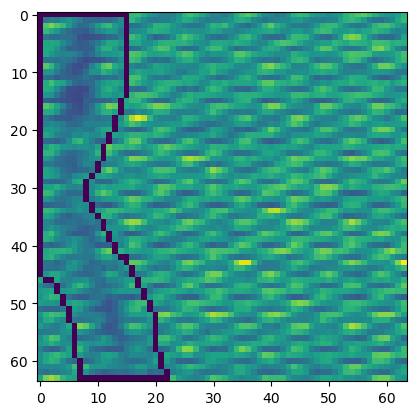

831.0
--------------------------------


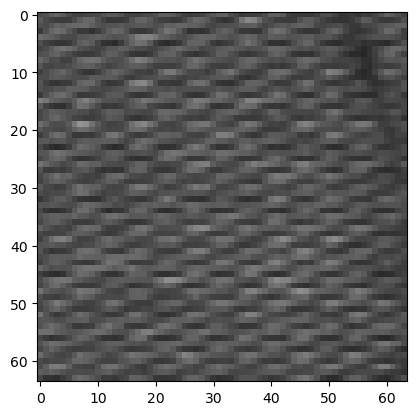

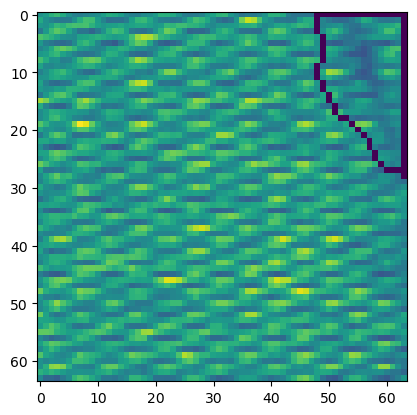

308.0
--------------------------------


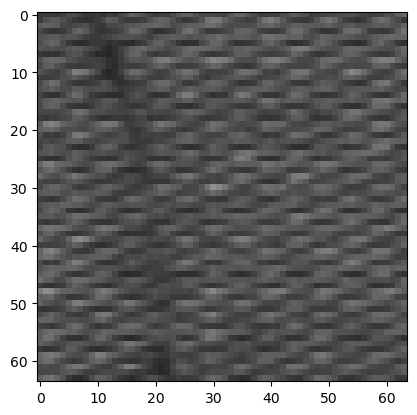

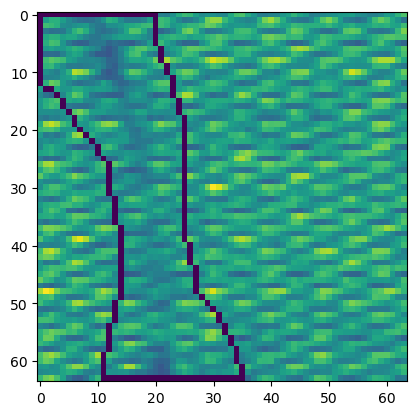

1073.5
--------------------------------


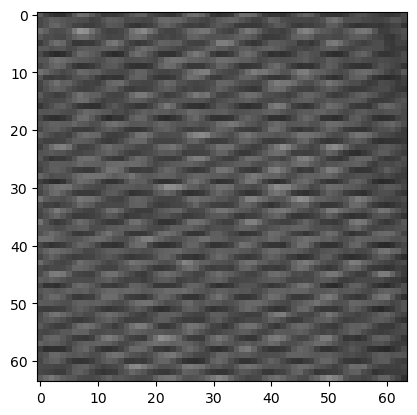

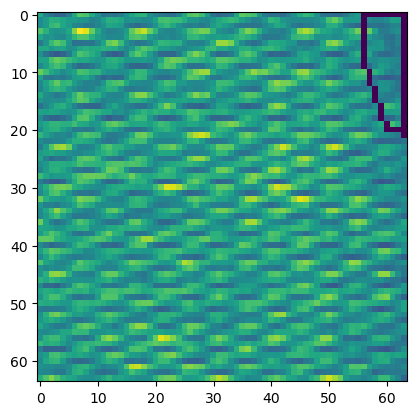

116.5
--------------------------------


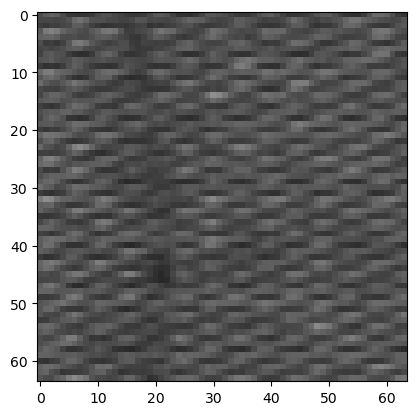

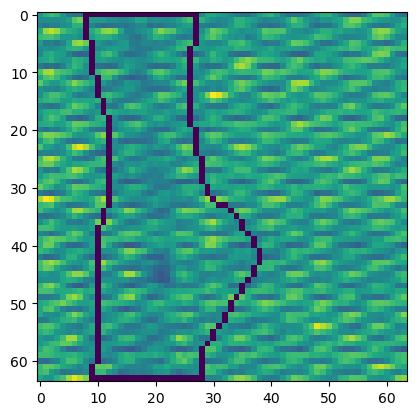

1235.5
--------------------------------


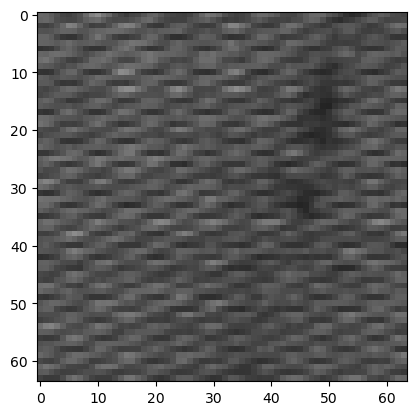

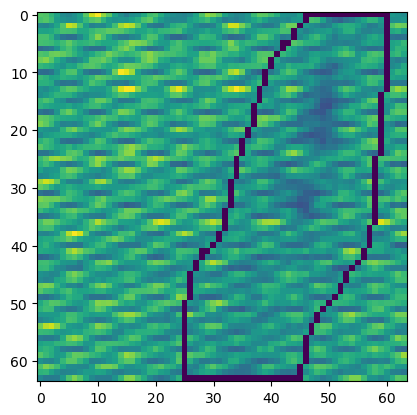

1434.0
--------------------------------


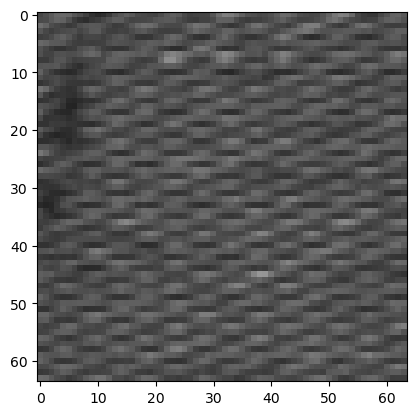

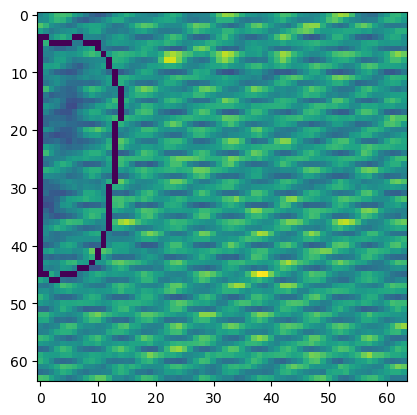

490.0
--------------------------------


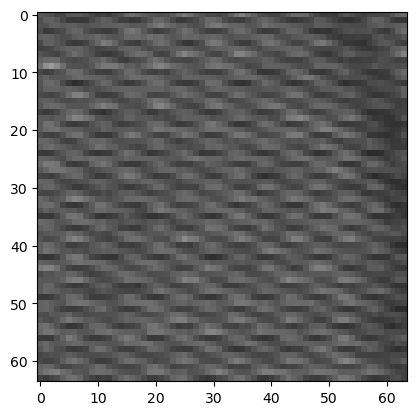

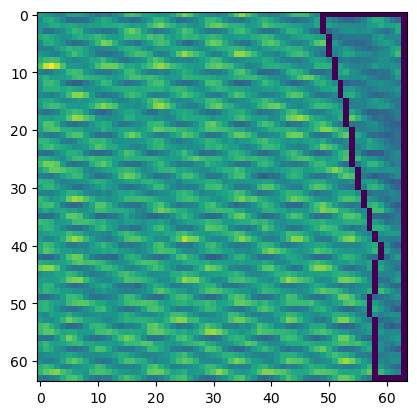

500.5
--------------------------------


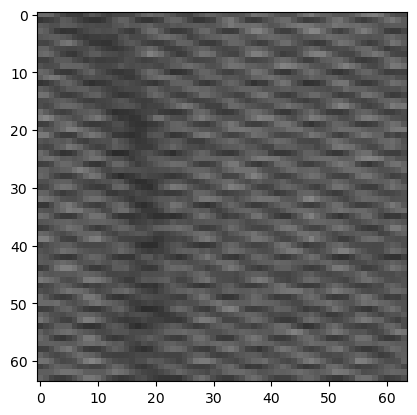

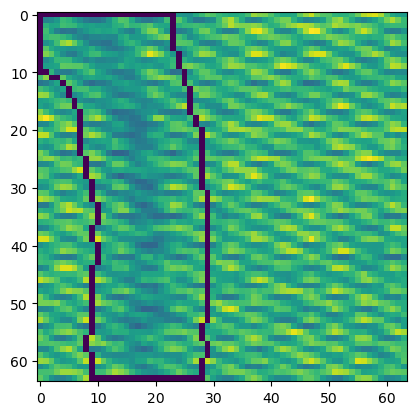

1292.0
--------------------------------


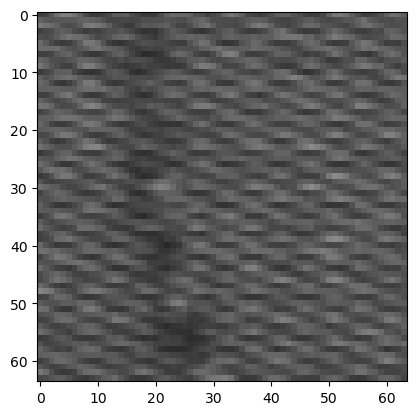

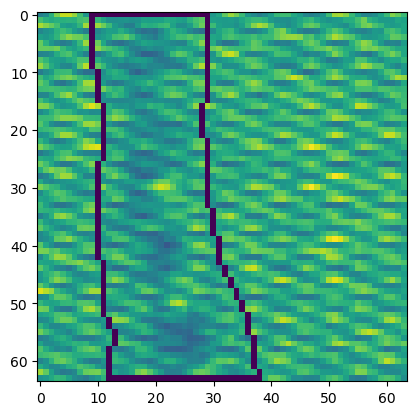

1297.0
--------------------------------


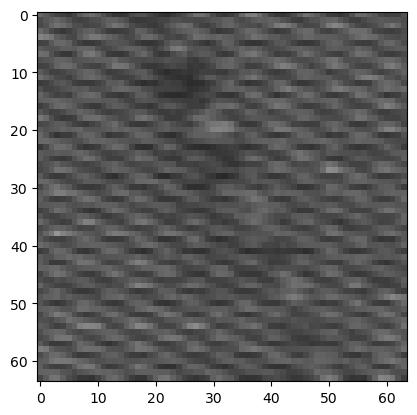

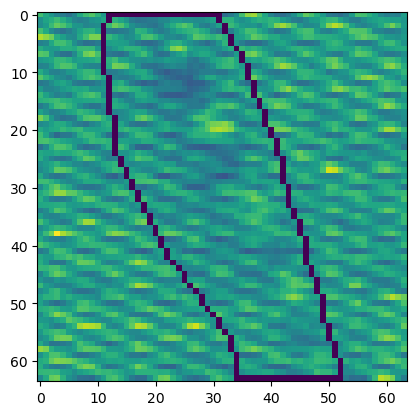

1471.5
--------------------------------


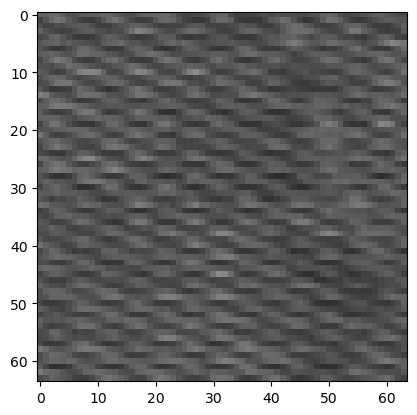

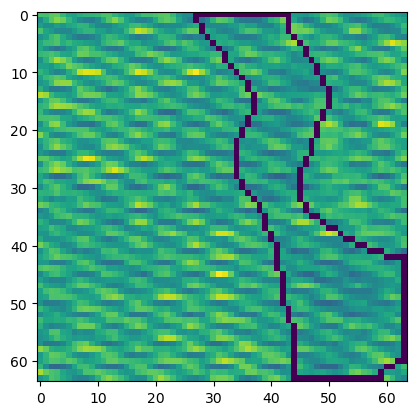

947.0
--------------------------------


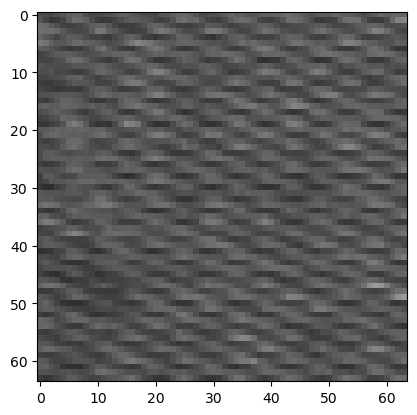

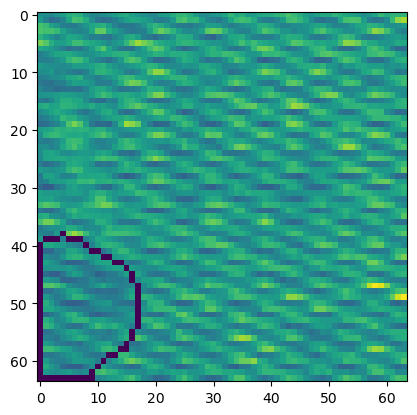

338.0
--------------------------------


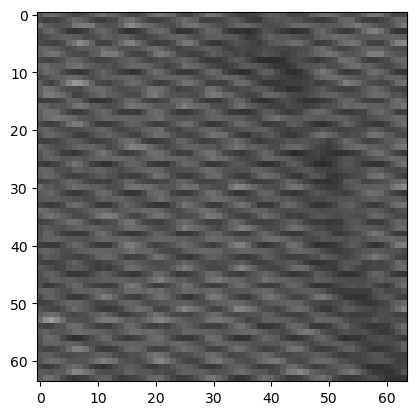

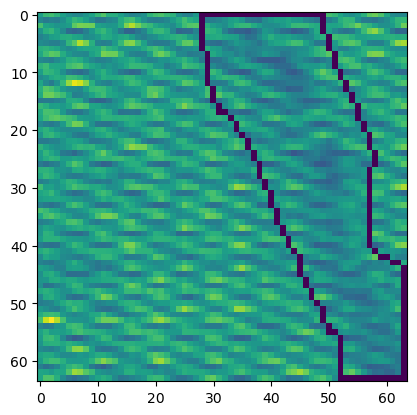

1129.0
--------------------------------


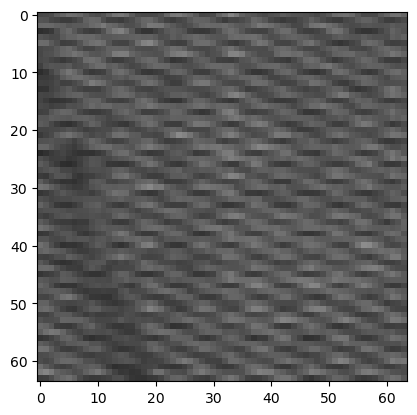

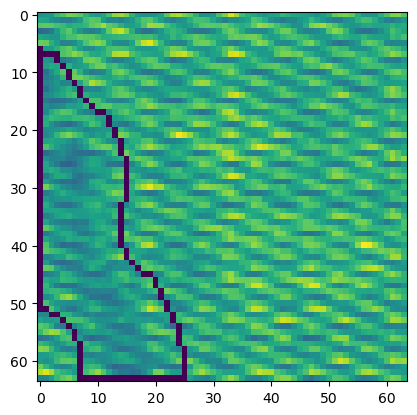

808.0
--------------------------------


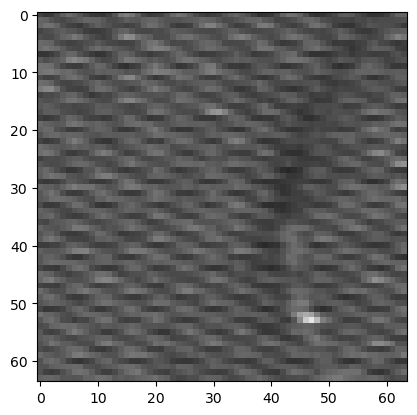

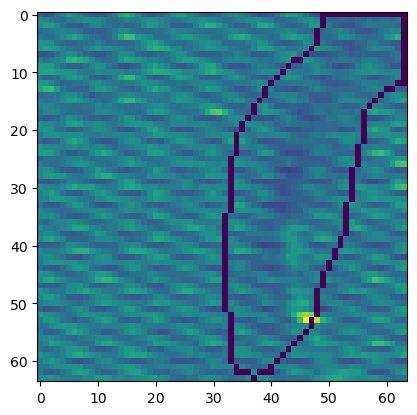

1104.5


In [79]:
num = 0

for im in defectTilesIms:
    result, imageMean, blobMean,blob_area, exitCode = twoPassInspection(im, bestThresh, bestPixThresh, bestLightBlur, bestErrode, bestBlur)
    if (exitCode == 0):
        print("--------------------------------")
        plt.imshow(im)
        plt.show()
        if exitCode == 0:
            plt.imshow(result)
            plt.show()
            print(blob_area)
        num = num+ 1
        
        if num == 20:
            break
    


--------------------------------


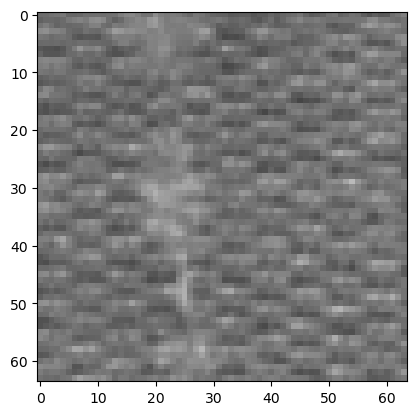

--------------------------------


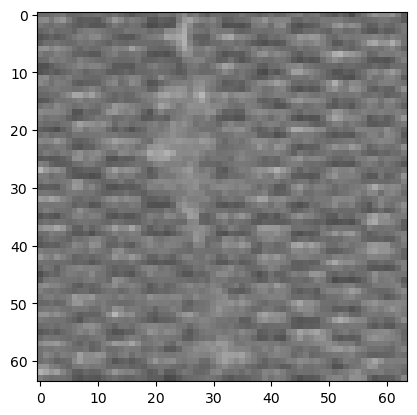

--------------------------------


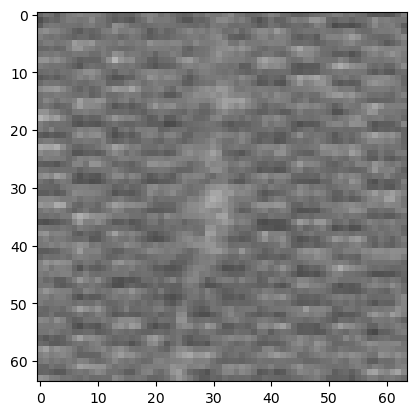

--------------------------------


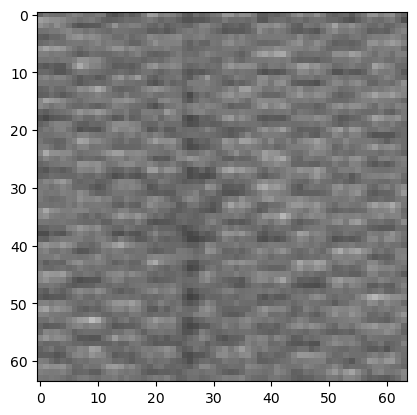

--------------------------------


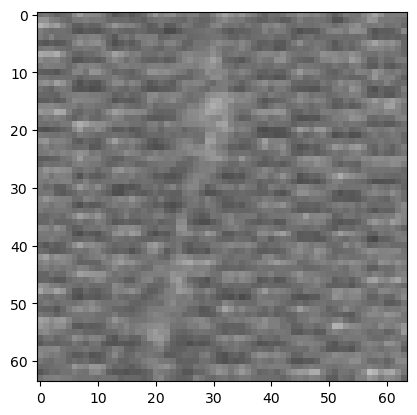

--------------------------------


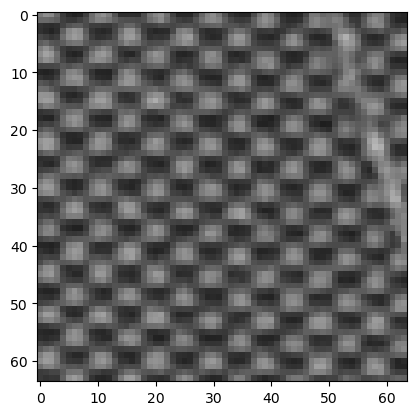

--------------------------------


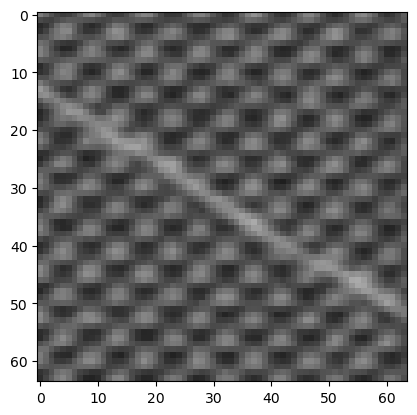

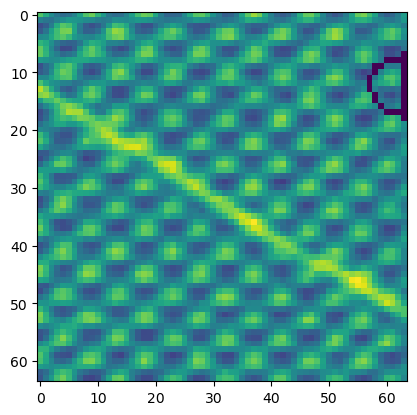

45.5
--------------------------------


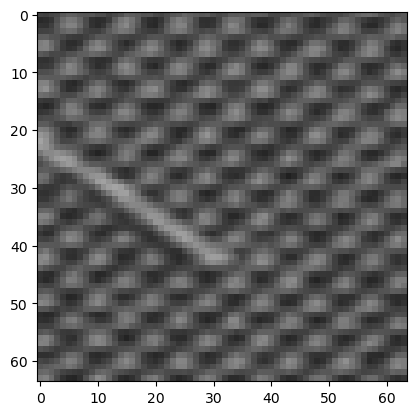

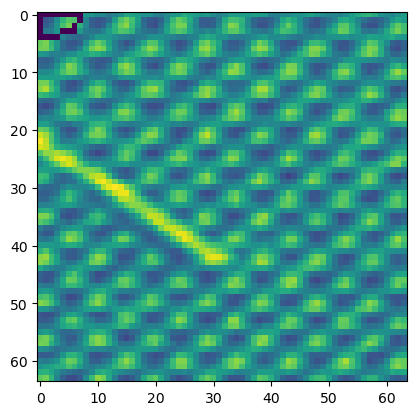

23.0
--------------------------------


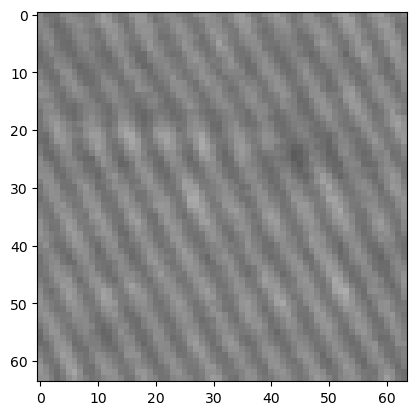

--------------------------------


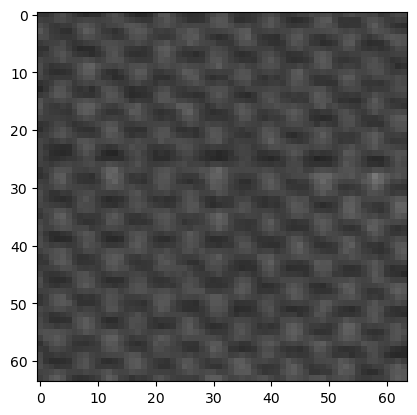

--------------------------------


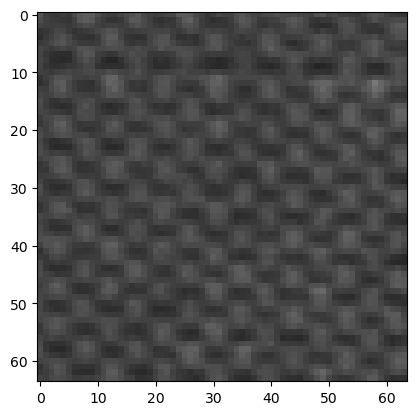

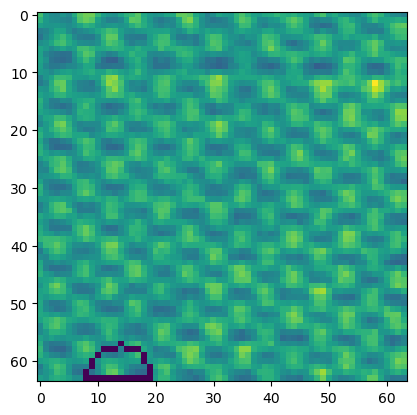

47.5
--------------------------------


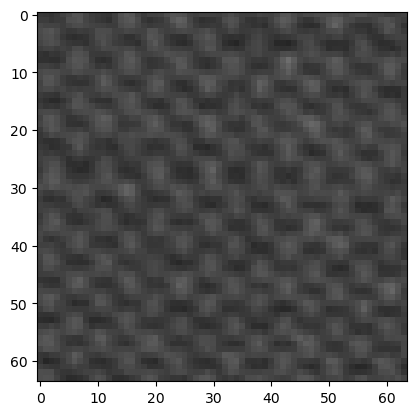

--------------------------------


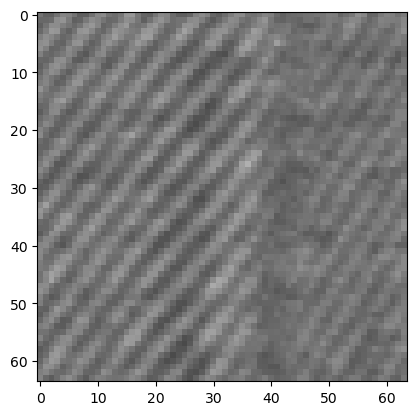

--------------------------------


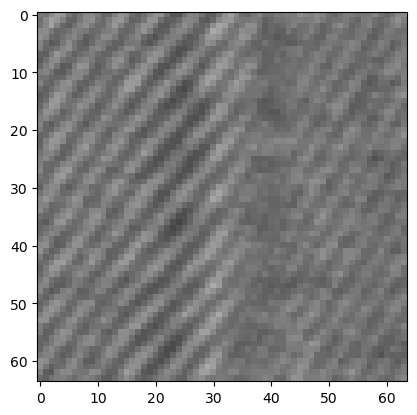

--------------------------------


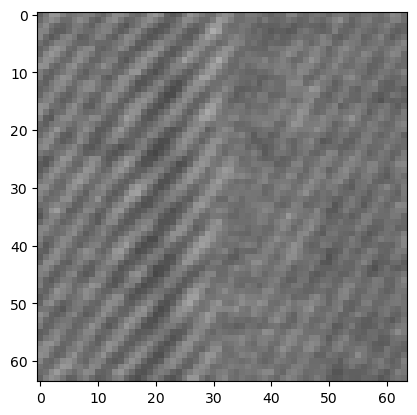

--------------------------------


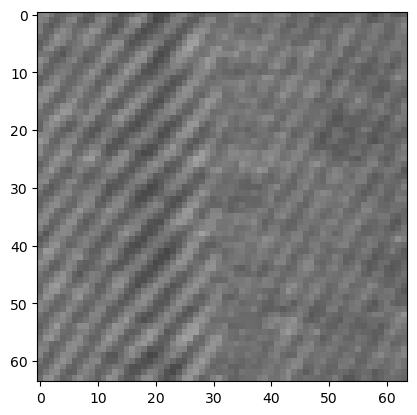

--------------------------------


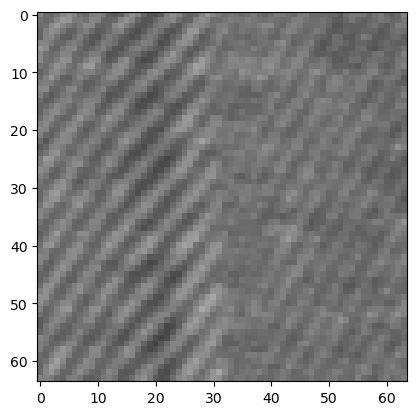

--------------------------------


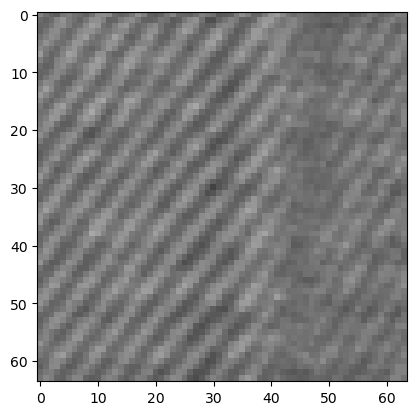

--------------------------------


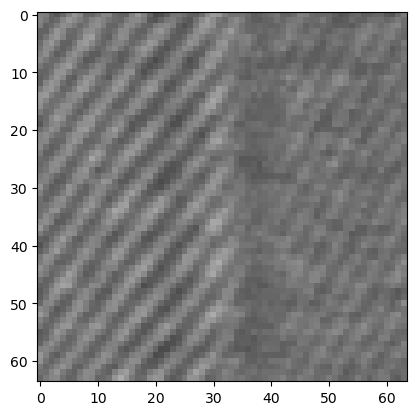

--------------------------------


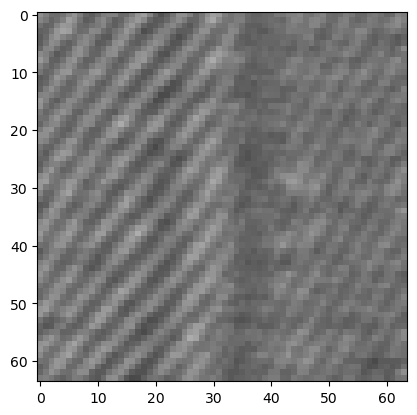

In [80]:
num = 0

for im in defectTilesIms:
    result, imageMean, blobMean,blob_area, exitCode = twoPassInspection(im, bestThresh, bestPixThresh, bestLightBlur, bestErrode, bestBlur)
    if (exitCode > 0):
        print("--------------------------------")
        plt.imshow(im)
        plt.show()
        if exitCode == 1:
            plt.imshow(result)
            plt.show()
            print(blob_area)
        num = num+ 1
        
        if num == 20:
            break
    


--------------------------------


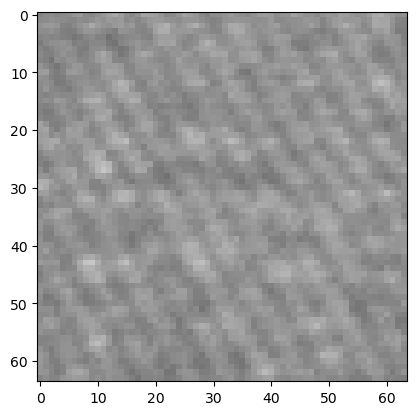

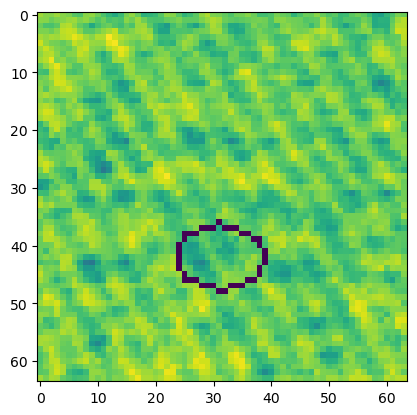

128.0
--------------------------------


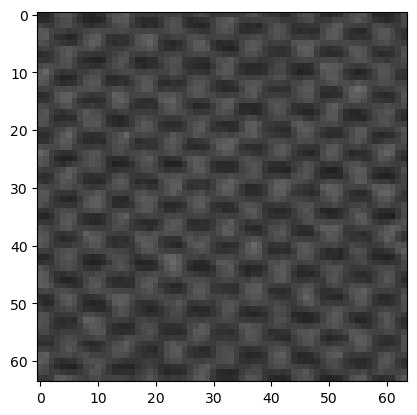

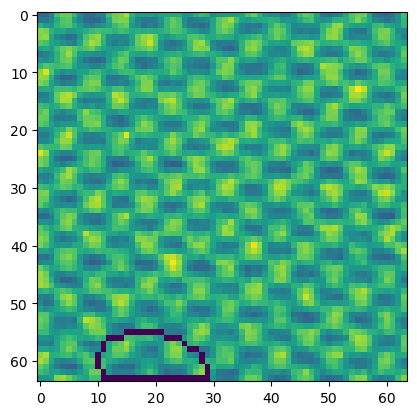

124.5
--------------------------------


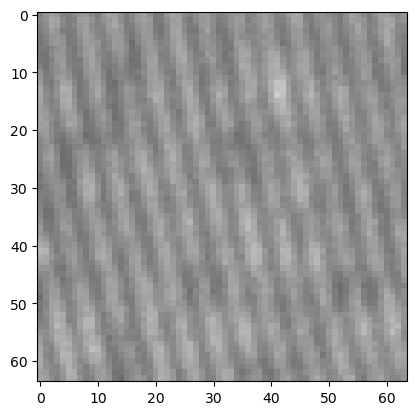

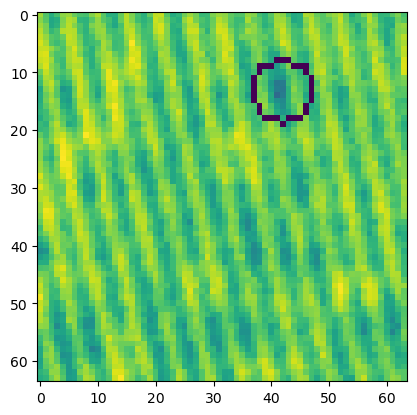

85.0
--------------------------------


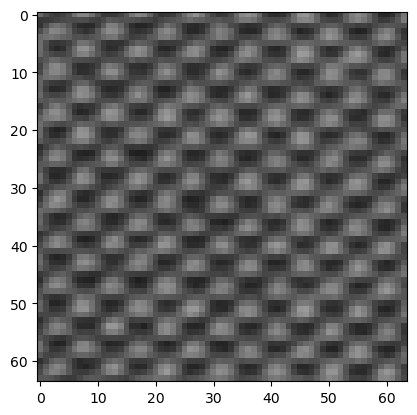

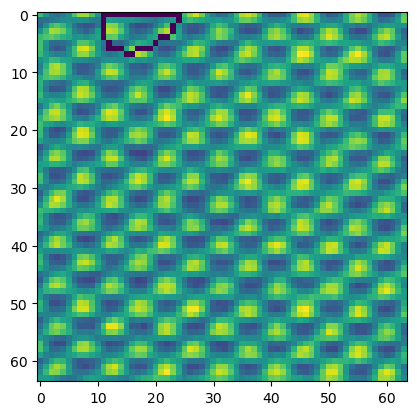

67.5
--------------------------------


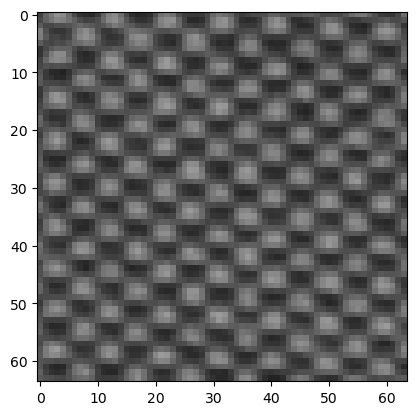

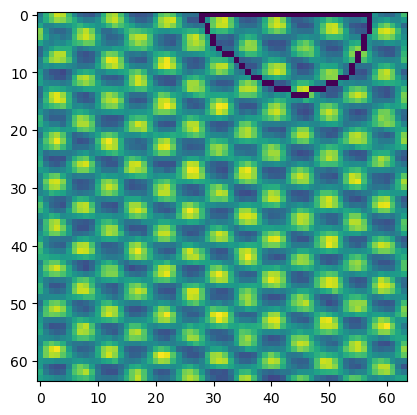

290.0
--------------------------------


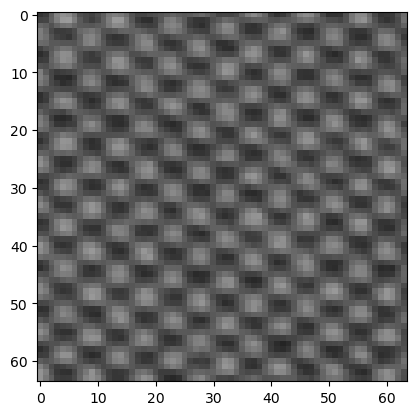

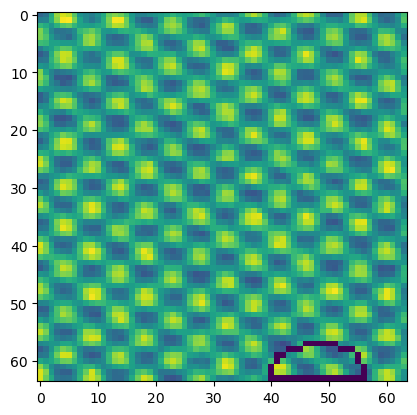

79.0
--------------------------------


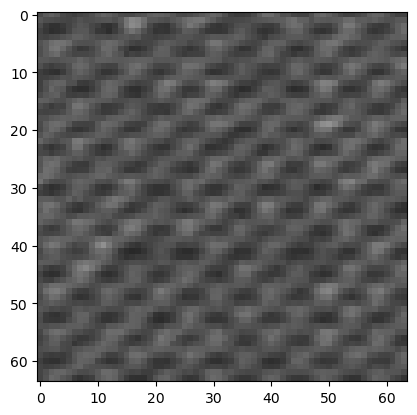

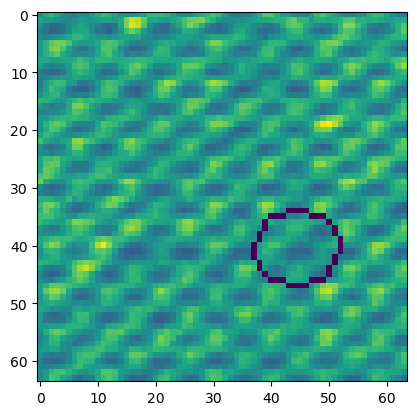

147.0
--------------------------------


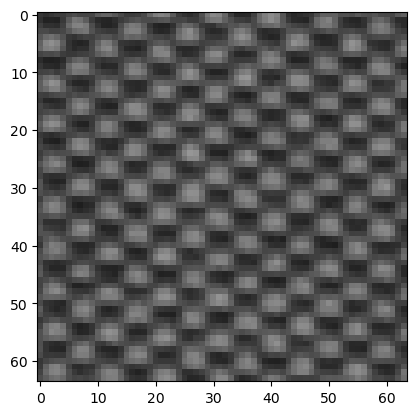

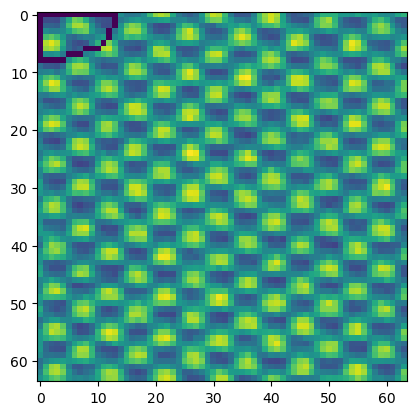

84.5
--------------------------------


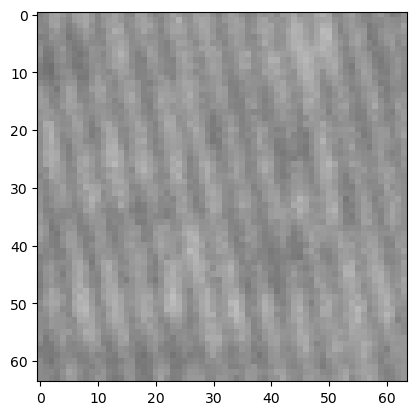

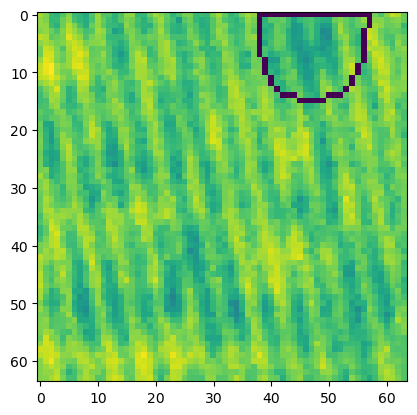

236.5
--------------------------------


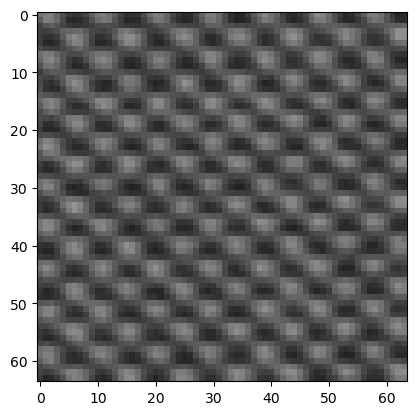

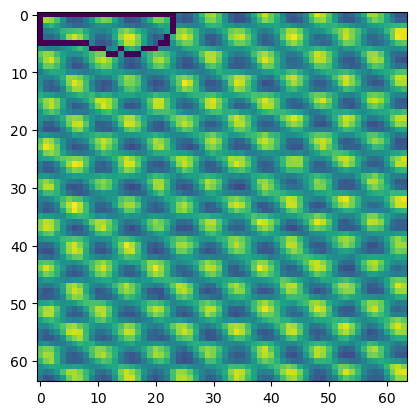

130.5
--------------------------------


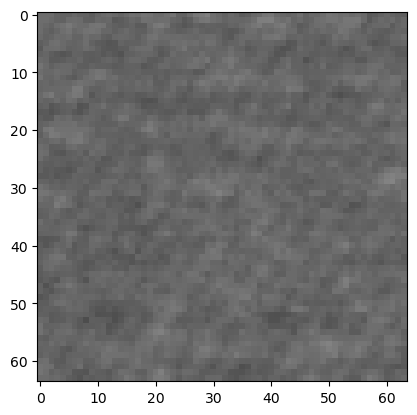

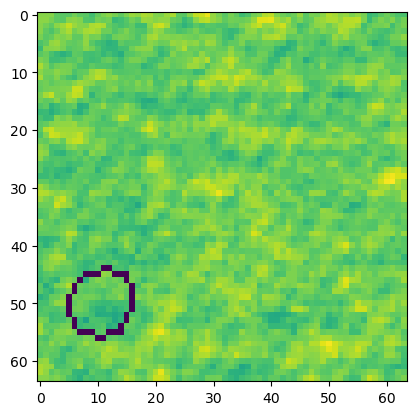

99.0
--------------------------------


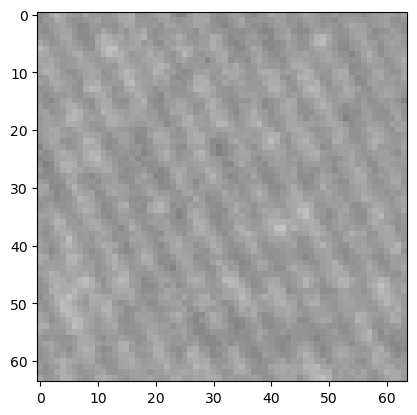

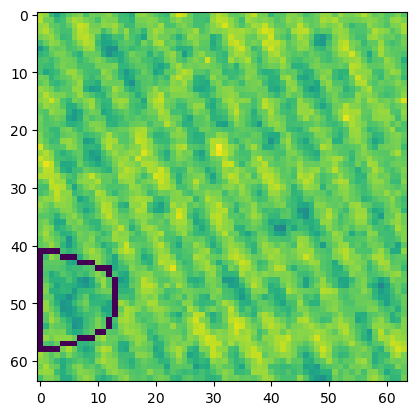

177.5
--------------------------------


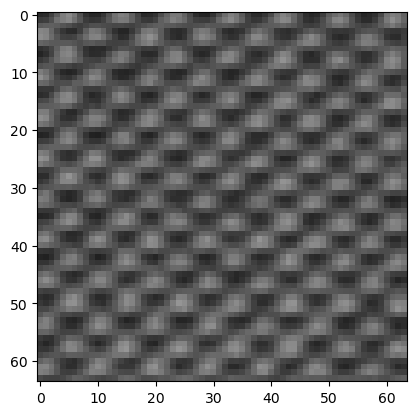

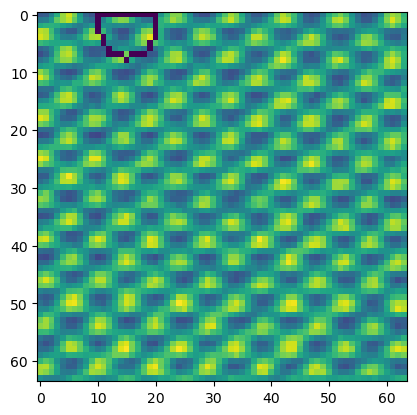

63.0
--------------------------------


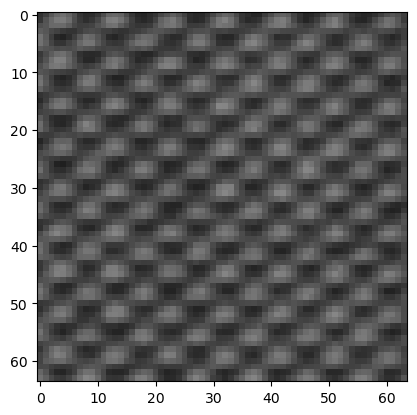

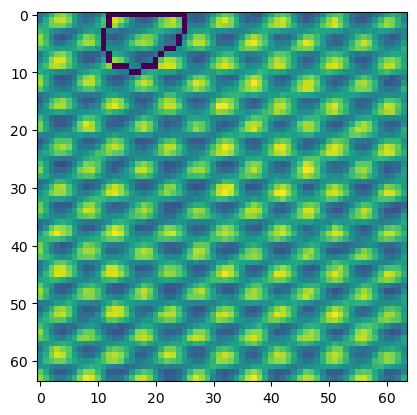

106.5
--------------------------------


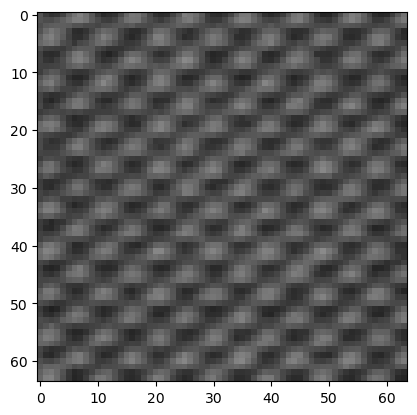

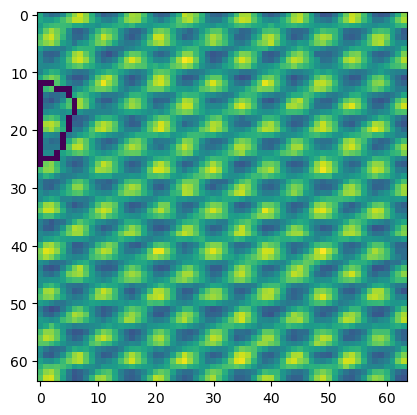

60.0
--------------------------------


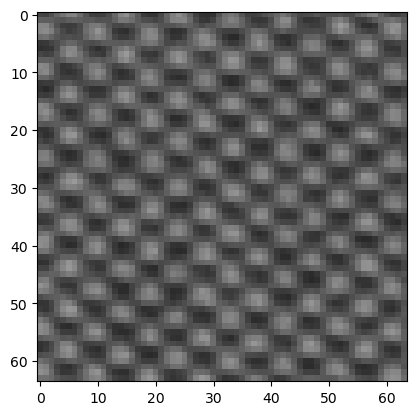

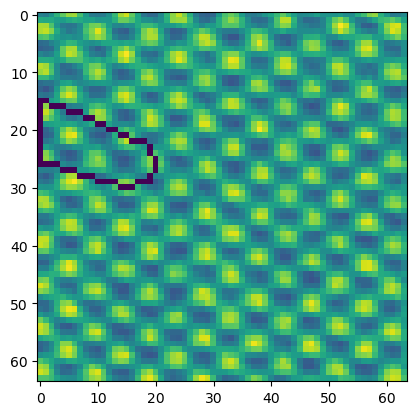

182.5
--------------------------------


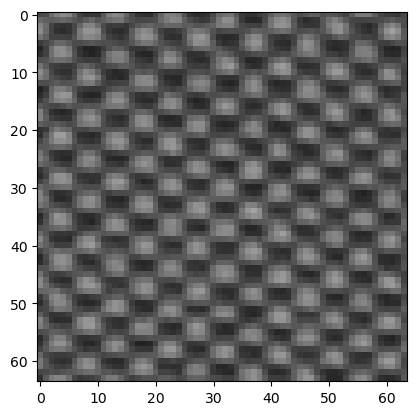

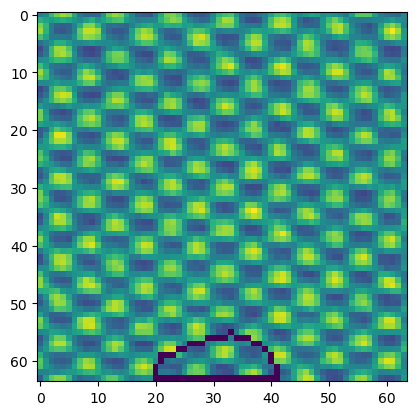

119.0
--------------------------------


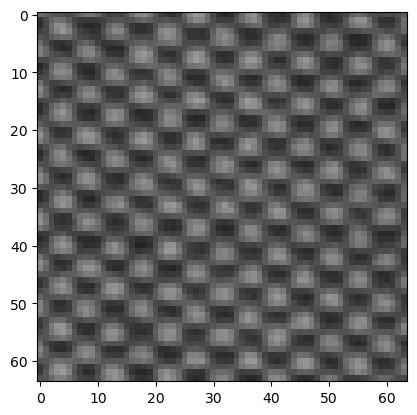

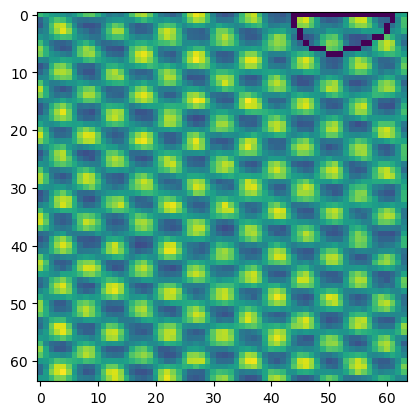

87.5
--------------------------------


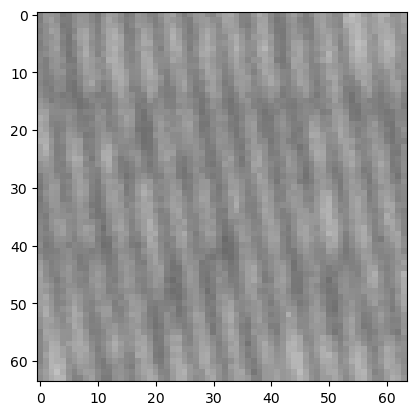

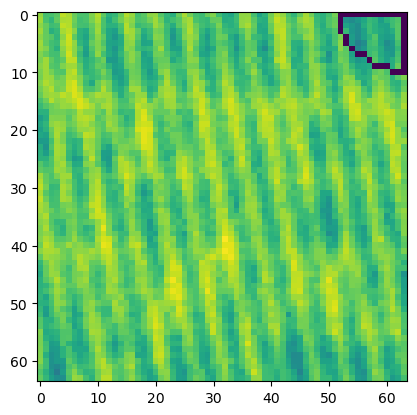

86.0
--------------------------------


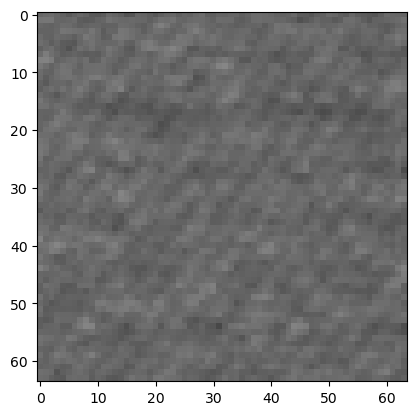

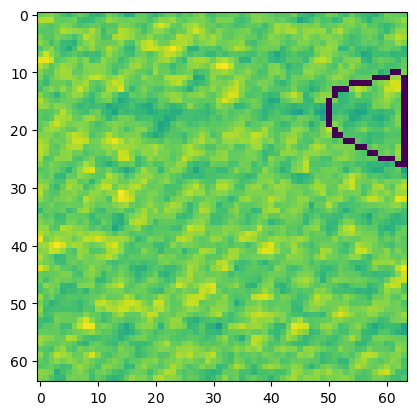

149.5


In [81]:
num = 0

for im in goodTilesIms:
    result, imageMean, blobMean,blob_area, exitCode = twoPassInspection(im, bestThresh, bestPixThresh, bestLightBlur, bestErrode, bestBlur)
    if (exitCode == 0):
        print("--------------------------------")
        plt.imshow(im)
        plt.show()
        plt.imshow(result)
        plt.show()
        print(blob_area)
        num = num+ 1
        
        if num == 20:
            break
    


In [82]:
# with out using 2 pass

TrueNoDefect = 0
FalseNoDefect  = 0
times = []

for im in goodTilesIms:
    start = time.perf_counter()
    result, imageMean, blobMean,blob_area, exitCode = findDefect(im, bestThresh, bestPixThresh, bestLightBlur, bestErrode, bestBlur)
    times.append(time.perf_counter() - start)
    if (exitCode > 0):
        TrueNoDefect = TrueNoDefect +1
    else:
        FalseNoDefect = FalseNoDefect +1
        
print(TrueNoDefect, FalseNoDefect)
    
TrueDefect = 0
FalseDefect  = 0

for im in defectTilesIms:
    start = time.perf_counter()
    result, imageMean, blobMean,blob_area, exitCode = findDefect(im, bestThresh, bestPixThresh, bestLightBlur, bestErrode, bestBlur)
    times.append(time.perf_counter() - start)
    if (exitCode == 0):
        TrueDefect = TrueDefect +1
    else:
        FalseDefect = FalseDefect +1
        
print(TrueDefect, FalseDefect)

print("Correctly computed good tiles =", TrueNoDefect, ",Fasly computed good tiles =", FalseNoDefect)
print("Correctly computed defcet tiles =", TrueDefect, ",Fasly computed defect tiles =", FalseDefect)
Accuracy = 100 * ((TrueNoDefect+TrueDefect) / (TrueNoDefect+TrueDefect+FalseNoDefect+FalseDefect))
print("Accuracy of", Accuracy)
print("with time per tile:", sum(times) / len(times))

833 167
738 171
Correctly computed good tiles = 833 ,Fasly computed good tiles = 167
Correctly computed defcet tiles = 738 ,Fasly computed defect tiles = 171
Accuracy of 82.2943949711891
with time per tile: 0.00017670900748741134


Using Averaage Accuracy

In [83]:
bestAcc = 0
theshHolds = [50,100,150,200,250,300]
pixTheshHolds = [50,60,70,80,90,100,110,120,140]

bestThresh = 0
bestPixThresh = 0




for thresh in theshHolds:
    for pixThresh in pixTheshHolds:
        TrueNoDefect = 0
        FalseNoDefect  = 0
        TrueDefect = 0
        FalseDefect  = 0
        for im in goodTilesIms:
            result, imageMean, blobMean,blob_area, exitCode = twoPassInspection(im, thresh, pixThresh, 5, 5, 15)
            if (exitCode > 0):
                TrueNoDefect = TrueNoDefect +1
            else:
                FalseNoDefect = FalseNoDefect +1

        for im in defectTilesIms:
            result, imageMean, blobMean,blob_area, exitCode = twoPassInspection(im, thresh, pixThresh, 5, 5, 15)
            if (exitCode == 0):
                TrueDefect = TrueDefect +1
            else:
                FalseDefect = FalseDefect +1
                
        accD = 100 * ((TrueDefect) / (TrueDefect+FalseDefect))
        accN = 100 * ((TrueNoDefect) / (TrueNoDefect+FalseNoDefect))
        accC = (accD + accN) / 2
        
        print(thresh, pixThresh, accC)
        print(TrueNoDefect, FalseNoDefect)
        print(TrueDefect, FalseDefect)
        print("---------------")

        if accC > bestAcc:
            bestThresh = thresh
            bestPixThresh = pixThresh
            bestAcc = accC
                    

50 50 54.245434543454344
998 2
79 830
---------------
50 60 55.3505500550055
997 3
100 809
---------------
50 70 71.07739273927393
943 57
435 474
---------------
50 80 81.12381738173818
859 141
694 215
---------------
50 90 83.2591309130913
839 161
751 158
---------------
50 100 83.5893289328933
806 194
787 122
---------------
50 110 75.72948294829483
618 382
815 94
---------------
50 120 61.60951595159516
329 671
821 88
---------------
50 140 55.21958195819582
188 812
833 76
---------------
100 50 54.13542354235423
998 2
77 832
---------------
100 60 54.85049504950495
998 2
90 819
---------------
100 70 66.61677667766777
977 23
323 586
---------------
100 80 77.09312431243124
917 83
568 341
---------------
100 90 81.0436193619362
897 103
658 251
---------------
100 100 82.2538503850385
875 125
700 209
---------------
100 110 78.87403740374037
770 230
734 175
---------------
100 120 68.49906490649064
557 443
739 170
---------------
100 140 60.0541804180418
365 635
760 149
-------------

In [84]:
print("best threshold:", bestThresh)
print("best pix threshold:", bestPixThresh)
print("with acc:", bestAcc)

best threshold: 50
best pix threshold: 100
with acc: 83.5893289328933


In [85]:
bestLightBlur = 0
bestErrode = 0
bestBlur = 0

bestAcc = 0


for lightBlur in range(1,10):
    for errode in range(1,10):
        for blur in range(1,20):
            TrueNoDefect = 0
            FalseNoDefect  = 0
            TrueDefect = 0
            FalseDefect  = 0
            for im in goodTilesIms:
                result, imageMean, blobMean,blob_area, exitCode = twoPassInspection(im, bestThresh, bestPixThresh, lightBlur, errode, blur)
                if (exitCode > 0):
                    TrueNoDefect = TrueNoDefect +1
                else:
                    FalseNoDefect = FalseNoDefect +1

            for im in defectTilesIms:
                result, imageMean, blobMean,blob_area, exitCode = twoPassInspection(im, bestThresh, bestPixThresh, lightBlur, errode, blur)
                if (exitCode == 0):
                    TrueDefect = TrueDefect +1
                else:
                    FalseDefect = FalseDefect +1
                    
            accD = 100 * ((TrueDefect) / (TrueDefect+FalseDefect))
            accN = 100 * ((TrueNoDefect) / (TrueNoDefect+FalseNoDefect))
            accC = (accD + accN) / 2

            if accC > bestAcc:
                bestLightBlur = lightBlur
                bestErrode = errode
                bestBlur = blur
                bestAcc = accC

In [86]:
print("best threshold:", bestThresh)
print("best pix threshold:", bestPixThresh)
print("best LightBlur:", bestLightBlur)
print("best errode:", bestErrode)
print("best blur:", bestBlur)
print("with accuracy of:", bestAcc)

best threshold: 50
best pix threshold: 100
best LightBlur: 6
best errode: 7
best blur: 16
with accuracy of: 85.10456545654566


In [87]:
TrueNoDefect = 0
FalseNoDefect  = 0
times = []

for im in goodTilesIms:
    start = time.perf_counter()
    result, imageMean, blobMean,blob_area, exitCode = twoPassInspection(im, bestThresh, bestPixThresh, bestLightBlur, bestErrode, bestBlur)
    times.append(time.perf_counter() - start)
    if (exitCode > 0):
        TrueNoDefect = TrueNoDefect +1
    else:
        FalseNoDefect = FalseNoDefect +1
        
print(TrueNoDefect, FalseNoDefect)
    
TrueDefect = 0
FalseDefect  = 0

for im in defectTilesIms:
    start = time.perf_counter()
    result, imageMean, blobMean,blob_area, exitCode = twoPassInspection(im, bestThresh, bestPixThresh, bestLightBlur, bestErrode, bestBlur)
    times.append(time.perf_counter() - start)
    if (exitCode == 0):
        TrueDefect = TrueDefect +1
    else:
        FalseDefect = FalseDefect +1
        
print(TrueDefect, FalseDefect)

print("Correctly computed good tiles =", TrueNoDefect, ",Fasly computed good tiles =", FalseNoDefect)
print("Correctly computed defcet tiles =", TrueDefect, ",Fasly computed defect tiles =", FalseDefect)
Accuracy = 100 * ((TrueNoDefect+TrueDefect) / (TrueNoDefect+TrueDefect+FalseNoDefect+FalseDefect))
print("Accuracy of", Accuracy)
print("with time per tile:", sum(times) / len(times))

789 211
830 79
Correctly computed good tiles = 789 ,Fasly computed good tiles = 211
Correctly computed defcet tiles = 830 ,Fasly computed defect tiles = 79
Accuracy of 84.80880041906758
with time per tile: 0.00034026013291599456
